# Group 8 Assignment

#### Objective:
To determine if there is a relationship between the number of home runs (HR) baseball players hits and and the number of strikeouts (SO) they have.  Specifically, we want to determine if SO can be used to predict HR.  Our rationale for there being a correlation is the hypothesis that players who hit more home runs will swing the bat more often and therefore will also have more strikeouts.

#### Dataset:
http://www.seanlahman.com/baseball-archive/statistics/
Specifically the "Batting.csv" file
Captures batting data for professional baseball players from 1871 to 2020
108,790 rows of data
Multiple columns (variables), but the 2 variables we are interested in are HR (number of home runs) and SO (number of strikeouts)

#### Proposed Analysis:
We will be building a predictive model using the OLS linear regression method.  In the model, HR will be the dependent variable and SO will be the independent variable.  We will examine all years of data, then do exploratory analyses to determine if the relationship between HR and SO are different depending on the era of baseball.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

from sklearn.preprocessing import OrdinalEncoder
from statsmodels.formula.api import ols 
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
%matplotlib inline

# Importing CSV File and Focusing The Dataframe

In [2]:
df_full = pd.read_csv(".../Batting.csv")
df_full

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  3B  HR   RBI   SB   CS  BB    SO  IBB  HBP   SH   SF  GIDP
0       abercda01    1871      1    TRO  NaN   1    4   0   0   0   0   0   0.0  0.0  0.0   0   0.0  NaN  NaN  NaN  NaN   0.0
1        addybo01    1871      1    RC1  NaN  25  118  30  32   6   0   0  13.0  8.0  1.0   4   0.0  NaN  NaN  NaN  NaN   0.0
2       allisar01    1871      1    CL1  NaN  29  137  28  40   4   5   0  19.0  3.0  1.0   2   5.0  NaN  NaN  NaN  NaN   1.0
3       allisdo01    1871      1    WS3  NaN  27  133  28  44  10   2   2  27.0  1.0  1.0   0   2.0  NaN  NaN  NaN  NaN   0.0
4       ansonca01    1871      1    RC1  NaN  25  120  29  39  11   3   0  16.0  6.0  2.0   2   1.0  NaN  NaN  NaN  NaN   0.0
...           ...     ...    ...    ...  ...  ..  ...  ..  ..  ..  ..  ..   ...  ...  ...  ..   ...  ...  ...  ...  ...   ...
108784  zimmebr02    2020      1    BAL   AL   2    0   0   0   0   0   0   0.0  0.0  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0
108785  zimmejo02    2020      1    DET   AL   3    0   0   0   0   0   0   0.0  0.0  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0
108786  zimmeky01    2020      1    KCA   AL  16    0   0   0   0   0   0   0.0  0.0  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0
108787  zuberty01    2020      1    KCA   AL  23    0   0   0   0   0   0   0.0  0.0  0.0   0   0.0  0.0  0.0  0.0  0.0   0.0
108788  zuninmi01    2020      1    TBA   AL  28   75   8  11   4   0   4  10.0  0.0  0.0   6  37.0  0.0  3.0  0.0  0.0   0.0

[108789 rows x 22 columns]

In [3]:
# Keep only the columns of interest for our Assignment
df_temp = pd.DataFrame(df_full, columns=['playerID','yearID','HR','SO'])
df_temp

playerID  yearID  HR    SO
0       abercda01    1871   0   0.0
1        addybo01    1871   0   0.0
2       allisar01    1871   0   5.0
3       allisdo01    1871   2   2.0
4       ansonca01    1871   0   1.0
...           ...     ...  ..   ...
108784  zimmebr02    2020   0   0.0
108785  zimmejo02    2020   0   0.0
108786  zimmeky01    2020   0   0.0
108787  zuberty01    2020   0   0.0
108788  zuninmi01    2020   4  37.0

[108789 rows x 4 columns]

# Inspecting The Data Frame

In [4]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108789 entries, 0 to 108788
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   playerID  108789 non-null  object 
 1   yearID    108789 non-null  int64  
 2   HR        108789 non-null  int64  
 3   SO        106689 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ MB


In [5]:
df_temp.nunique()

playerID    19898
yearID        150
HR             67
SO            209
dtype: int64

The data frame consists of player statistics for each year in baseball from 1871 to 2020. Since the same player can play in several seasons, the same playerID appears in multiple rows corresponding to different seasons.

For playerID, there are 19,898 unique players among the 108,789 total entries.

In [6]:
df_temp.isnull().sum()

playerID       0
yearID         0
HR             0
SO          2100
dtype: int64

# Dealing With Missing SO Values

There are 2,100 null values for SO.

There are a few ways we can deal with the 2,100 missing values for SO. We can try to impute a value based on grouping of similar characteristics for variables, we can fill in the missing values with the median or mean of the SO variable, or we can drop the rows with missing SO values.

Because we want to have the most accurate estimate of the association between HR and SO, we want to minimize bias and confounding, which may arise if we try to impute values for the missing data. As well, 2,100 missing values out of a total of 108,789 total entries represents only 1.9% of the total sample. Dropping the rows with missing values should have a negligible effect on the analyses.

Therefore, we feel it is most appropriate to drop the rows with missing SO values.

In [7]:
df = df_temp.dropna()

In [8]:
df.isnull().sum()

playerID    0
yearID      0
HR          0
SO          0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106689 entries, 0 to 108788
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   playerID  106689 non-null  object 
 1   yearID    106689 non-null  int64  
 2   HR        106689 non-null  int64  
 3   SO        106689 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.1+ MB


In [10]:
df.nunique()

playerID    19445
yearID        150
HR             67
SO            209
dtype: int64

# Feature Engineering To Create New Variable Based on Era of Baseball

https://thesportjournal.org/article/examining-perceptions-of-baseballs-eras/

According to this article, the different eras of baseball can be broken down generally as follows:
- Era1: Pre Dead Ball Era (1870-1900)
- Era2: Dead Ball Era (1901-1919)
- Era3: Live Ball Era (1920-1941)
- Era4: Integration Era (1942-1960)
- Era5: Expansion Era (1961-1976)
- Era6: Free Agency Era (1977-1993)
- Era7: Long Ball/Steroid Era (1994-2005)
- Era8: Post Steroid Era (2006-2020)

In [11]:
binera = [1870,1901,1920,1942,1961,1977,1994,2006,2021]
binera_labels = ['Era1','Era2','Era3','Era4','Era5','Era6','Era7','Era8']
df['eraID'] = pd.cut(df['yearID'], binera, right=False, labels = binera_labels)
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


playerID  yearID  HR    SO eraID
0       abercda01    1871   0   0.0  Era1
1        addybo01    1871   0   0.0  Era1
2       allisar01    1871   0   5.0  Era1
3       allisdo01    1871   2   2.0  Era1
4       ansonca01    1871   0   1.0  Era1
...           ...     ...  ..   ...   ...
108784  zimmebr02    2020   0   0.0  Era8
108785  zimmejo02    2020   0   0.0  Era8
108786  zimmeky01    2020   0   0.0  Era8
108787  zuberty01    2020   0   0.0  Era8
108788  zuninmi01    2020   4  37.0  Era8

[106689 rows x 5 columns]

In [12]:
df['eraID'].value_counts()

Era8    21459
Era6    17399
Era7    15458
Era5    13212
Era3    11670
Era4    11439
Era2     9424
Era1     6628
Name: eraID, dtype: int64

In [13]:
#Encode the era's incase we wanted to add to regression analysis
enc = OrdinalEncoder(categories=[binera_labels])
df['eraID_enc'] = enc.fit_transform(df[["eraID"]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Exploring Columns in the Data Frame and Data Visualization

In [14]:
df.describe()

yearID             HR             SO      eraID_enc
count  106689.000000  106689.000000  106689.000000  106689.000000
mean     1968.685647       2.893241      20.559814       4.216789
std        38.690629       6.419983      28.514873       2.199917
min      1871.000000       0.000000       0.000000       0.000000
25%      1940.000000       0.000000       1.000000       2.000000
50%      1977.000000       0.000000       9.000000       5.000000
75%      2002.000000       2.000000      29.000000       6.000000
max      2020.000000      73.000000     223.000000       7.000000

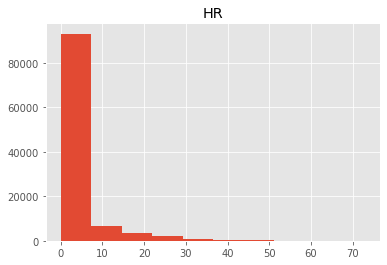

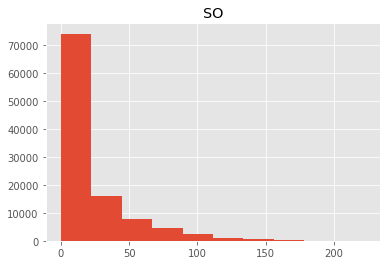

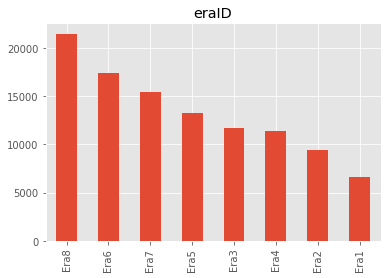

In [15]:
df_num = df[['HR','SO']]
df_cat = df[['eraID']]

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()
    
for i in df_cat.columns:
    df_cat[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

# Merging rows with the same 'playerID'

As already mentioned, the same player can play in several seasons, therefore the same playerID appears in multiple rows corresponding to different seasons.

After dropping rows with missing SO values, there are 19,445 unique players.

Since each observation should be an independent observation, we should merge rows with the same playerID (e.g., the same player but data for a different season).

In [16]:
aggregation_functions = {'HR': 'sum', 'SO': 'sum', 'eraID_enc':np.mean}
df_byplayerID = df.groupby(df['playerID'], as_index=False).aggregate(aggregation_functions)
#I added era, however its most likely not the best way to treat each player.
#This assumes the player belongs to the era they played in the most
df_byplayerID.eraID_enc = df_byplayerID.eraID_enc.round()
df_byplayerID

playerID   HR      SO  eraID_enc
0      aardsda01    0     2.0        7.0
1      aaronha01  755  1383.0        4.0
2      aaronto01   13   145.0        4.0
3       aasedo01    0     3.0        5.0
4       abadan01    0     5.0        6.0
...          ...  ...     ...        ...
19440   zupofr01    0     6.0        3.0
19441  zuvelpa01    2    50.0        5.0
19442  zuverge01    0    39.0        3.0
19443  zwilldu01   30   155.0        1.0
19444   zychto01    0     0.0        7.0

[19445 rows x 4 columns]

In [17]:
df_byplayerID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19445 entries, 0 to 19444
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   playerID   19445 non-null  object 
 1   HR         19445 non-null  int64  
 2   SO         19445 non-null  float64
 3   eraID_enc  19445 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 759.6+ KB


In [18]:
df_byplayerID.nunique()

playerID     19445
HR             394
SO            1169
eraID_enc        8
dtype: int64

In [19]:
df_byplayerID.isnull().sum()

playerID     0
HR           0
SO           0
eraID_enc    0
dtype: int64

In [20]:
df_byplayerID.describe()

HR            SO     eraID_enc
count  19445.000000  19445.000000  19445.000000
mean      15.874364    112.805657      3.909540
std       51.090849    235.376219      2.368685
min        0.000000      0.000000      0.000000
25%        0.000000      1.000000      2.000000
50%        0.000000     15.000000      4.000000
75%        5.000000    105.000000      6.000000
max      762.000000   2597.000000      7.000000

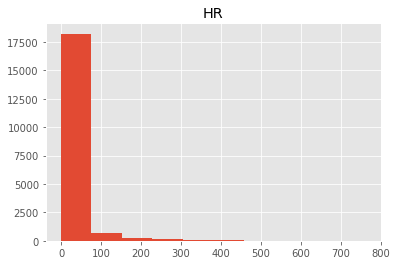

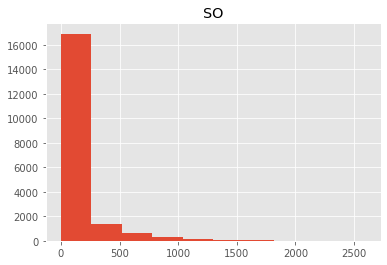

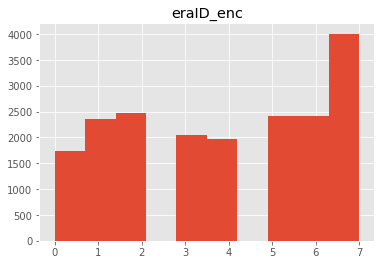

In [21]:
df_num = df_byplayerID[['HR','SO','eraID_enc']]

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

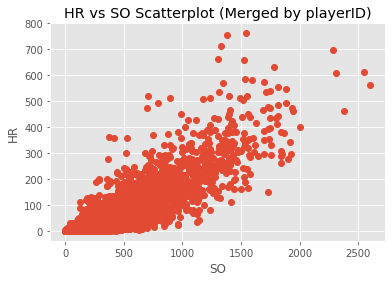

In [22]:
plt.plot(df_byplayerID.SO, df_byplayerID.HR, 'o')
plt.title('HR vs SO Scatterplot (Merged by playerID)')
plt.xlabel('SO')
plt.ylabel('HR')
plt.show()

# Start of Regression Analysis

#### Create a function that evaluates the regression analyis assumptions.

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def check_assumptions(dependent,
                      independent,
                      results):
    
    #First visualize all the independent varaibles
    if isinstance(independent, list):
        sns.pairplot(results[independent])
        plt.show()
    else:
        independent = list(independent)
        sns.pairplot(results[independent])
        plt.show()

    #Visually check for linearity
    for idx in independent:
        plt.plot(results[idx], results['y_true'], 'o')
        plt.title(f'{dependent} vs {idx} Scatterplot')
        plt.xlabel(idx)
        plt.ylabel(dependent)
        plt.show()

    #Plotting the actual vs predicted values
    fig, ax = plt.subplots(1,2)
    sns.regplot(x='y_pred', y='y_true', data=results, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_xlabel('Predicted', fontsize = 9)
    ax[0].set_ylabel('Y True', fontsize = 9)
    ax[0].set_title('Observed vs. Predicted Values', fontsize=9)
    sns.regplot(x='y_pred', y='residuals', data=results, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=9)
    ax[1].set_xlabel('Y Pred', fontsize = 9)
    ax[1].set_ylabel('Residuals', fontsize = 9)
    plt.show()

    #Mean of residuals
    print('=====Description of Residuals....')
    print(results['residuals'].describe())

    #Normality of residuals
    sns.distplot(results['residuals'], kde=True)
    plt.title('Normality of the residuals')
    plt.show()
    residuals_p_value = normal_ad(results['residuals'].values)[1]
    print('=====Normality check of residuals')
    print(f'The p-value for the Ander-Darling test is {residuals_p_value}')
    if residuals_p_value < 0.05:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
        
    sm.ProbPlot(results['residuals']).qqplot(line='s')
    plt.title('Q-Q plot')
    plt.show()

    #Check multicorrelation between independent variables
    sns.heatmap(results[independent].corr(), annot = True)
    plt.show()

    #Check autocorrelation
    smt.graphics.plot_acf(results['residuals'], lags=40 , alpha=0.05)
    plt.show()

    durbinWatson = durbin_watson(results['residuals'])
    print('=====Checking autocorrelation')
    print(f'The DurbinWatson coefficient is {durbinWatson}')
    if durbinWatson < 1.5:
        print('Potential for positive autocorrelation')
    elif durbinWatson > 2.5:
        print('Potential for negative autocorrelation')
    else:
        print('There is minimal autocorrelation')

    #Homoscedasticity
    plt.scatter(x=results.index, y=results.residuals, alpha=0.5)
    plt.plot(np.repeat(0, len(results)), color='darkorange', linestyle='--')
    plt.title('Residuals')
    plt.show() 

#### Create a function that removes the outliers from the dataframe

In [24]:
def identify_outliers(model, 
                      df,
                     student_resid_threshold_max = 3,
                     student_resid_threshold_min = -3,
                     model_param = 2):
    
    outlier_measures = model.get_influence()
    student_resid = outlier_measures.resid_studentized_external
    sr_index = np.where((student_resid > student_resid_threshold_max) | (student_resid < student_resid_threshold_min))[0]
    leverage = outlier_measures.hat_matrix_diag
    lev_index = np.where(leverage > (3 * (model_param/len(leverage))))[0]
    idx_to_remove = list(set(sr_index) & set(lev_index))
    #Remvoe outliers from df
    df_outliers_dropped = df.drop(df.index[idx_to_remove])
    df_outliers_dropped = df_outliers_dropped.reset_index(drop=True)
    return df_outliers_dropped

# Create a model using HR and SO

We start by creating a model using only HR and SO across all eras and years to determine if there is an 
overall relationship.

                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 6.927e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:01:17   Log-Likelihood:                -89321.
No. Observations:               19445   AIC:                         1.786e+05
Df Residuals:                   19443   BIC:                         1.787e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7625      0.190    -30.296      0.0

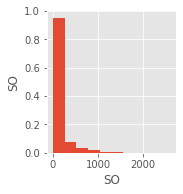

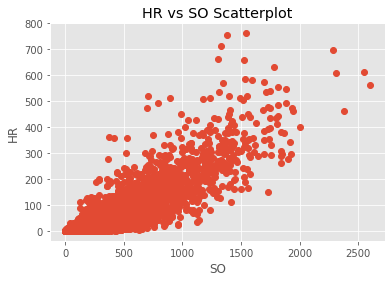

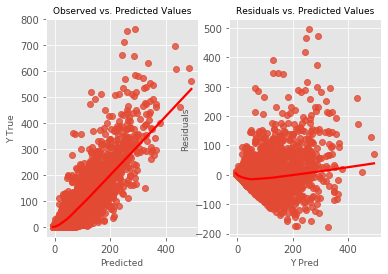

=====Description of Residuals....
count    1.944500e+04
mean    -3.756887e-15
std      2.391776e+01
min     -1.770621e+02
25%     -3.252436e+00
50%      4.350911e+00
75%      5.624656e+00
max      4.954946e+02
Name: residuals, dtype: float64


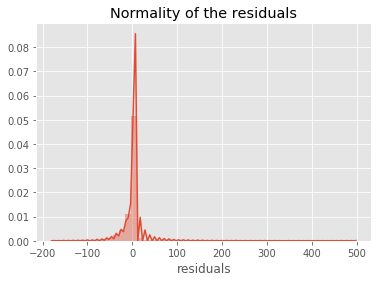

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


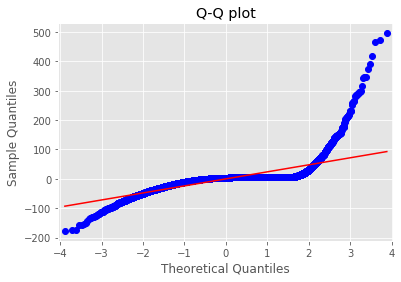

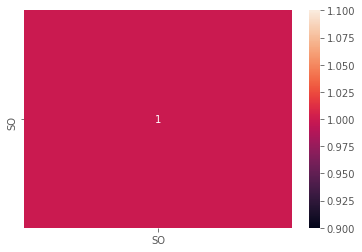

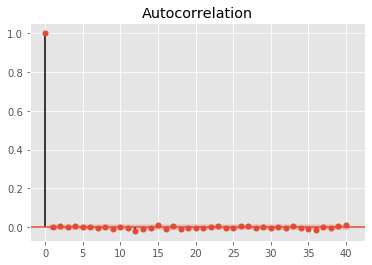

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9967383115758837
There is minimal autocorrelation


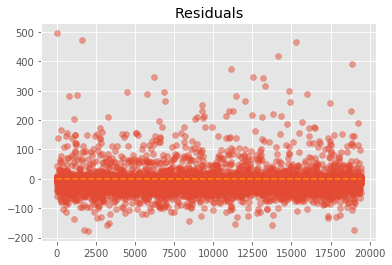

In [25]:
model = ols("HR ~ SO", data=df_num).fit()
df_results = pd.DataFrame({'y_true':df_num['HR'].values,
                           'SO':df_num['SO'].values,
                           'y_pred':model.predict(df_num[['SO']]),
                           'residuals':model.resid.values})
print(model.summary())
check_assumptions(dependent='HR', independent=['SO'], results=df_results)

# Add era into the analysis

                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 3.464e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:01:20   Log-Likelihood:                -89321.
No. Observations:               19445   AIC:                         1.786e+05
Df Residuals:                   19442   BIC:                         1.787e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0222      0.334    -18.039      0.0

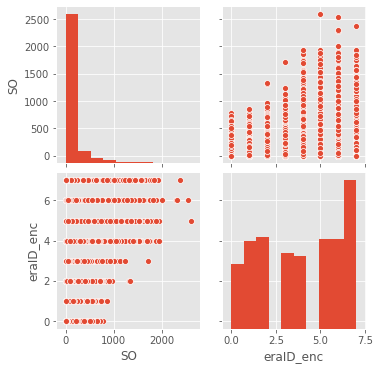

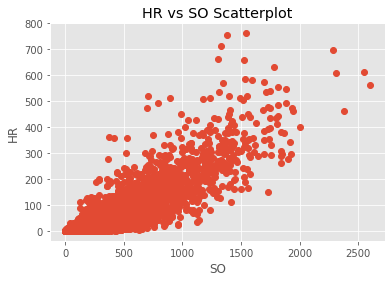

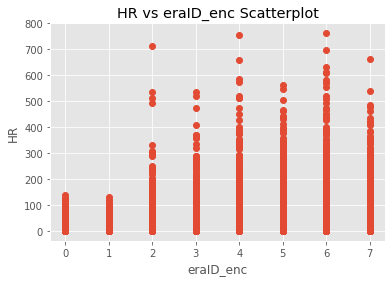

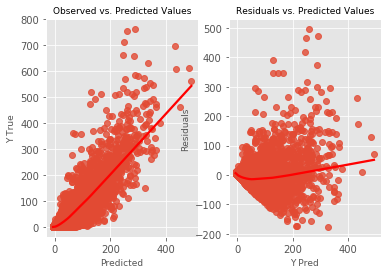

=====Description of Residuals....
count    1.944500e+04
mean    -6.852827e-14
std      2.391721e+01
min     -1.769122e+02
25%     -3.281011e+00
50%      4.347788e+00
75%      5.553586e+00
max      4.956110e+02
Name: residuals, dtype: float64


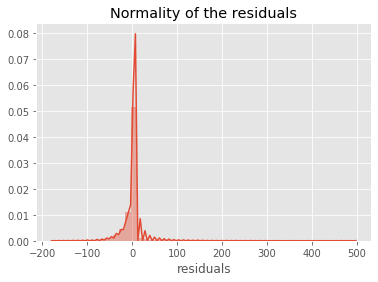

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


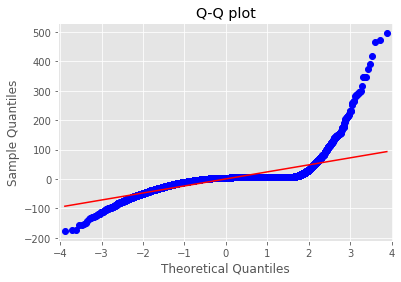

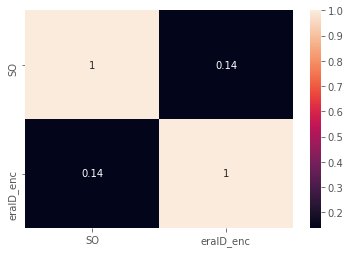

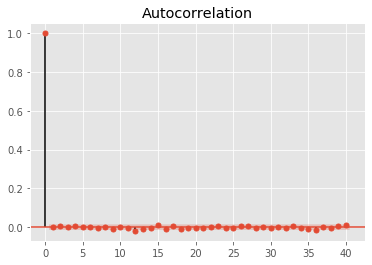

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9967014019537477
There is minimal autocorrelation


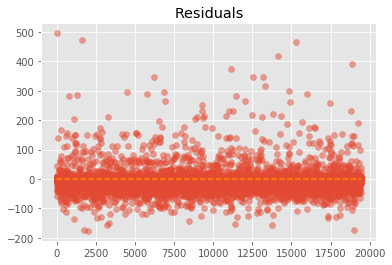

In [26]:
model = ols("HR ~ SO + eraID_enc", data=df_num).fit()
df_results = pd.DataFrame({'y_true':df_num['HR'].values,
                           'SO':df_num['SO'].values,
                           'eraID_enc':df_num['eraID_enc'].values,
                           'y_pred':model.predict(df_num[['SO','eraID_enc']]),
                           'residuals':model.resid.values})
print(model.summary())
check_assumptions(dependent='HR', independent=['SO', 'eraID_enc'], results=df_results)

#### As Era was not significant we will remove the outliers to see if they are influencing the results.

                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 9.189e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:02   Log-Likelihood:                -79804.
No. Observations:               19173   AIC:                         1.596e+05
Df Residuals:                   19171   BIC:                         1.596e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2230      0.125    -33.769      0.0

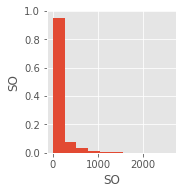

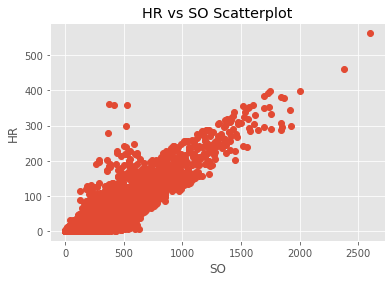

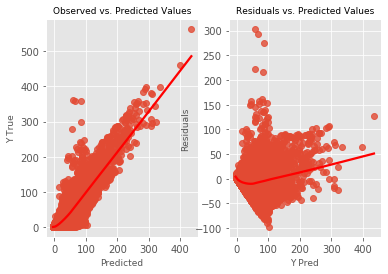

=====Description of Residuals....
count    1.917300e+04
mean    -9.126655e-15
std      1.554004e+01
min     -9.752813e+01
25%     -2.389958e+00
50%      3.207975e+00
75%      4.223042e+00
max      3.027964e+02
Name: residuals, dtype: float64


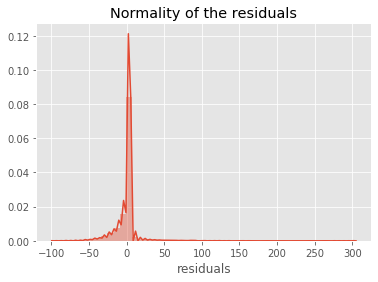

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


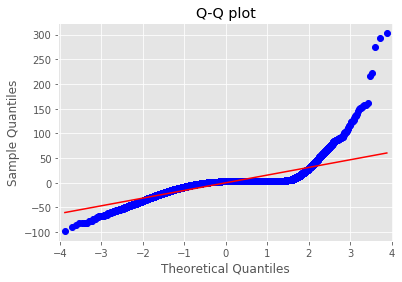

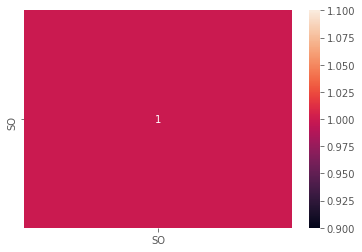

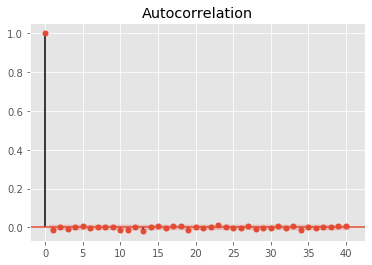

=====Checking autocorrelation
The DurbinWatson coefficient is 2.0230268064101447
There is minimal autocorrelation


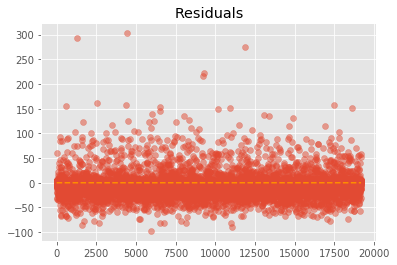

In [27]:
model = ols("HR ~ SO", data=df_num).fit()
df_OR = identify_outliers(model, df_num)

model_OR = ols("HR ~ SO", data=df_OR).fit()
df_results = pd.DataFrame({'y_true':df_OR['HR'].values,
                            'SO':df_OR['SO'].values,
                            'y_pred':model_OR.predict(df_OR[['SO']]),
                            'residuals':model_OR.resid.values})
print(model_OR.summary())
check_assumptions(dependent='HR', independent=['SO'], results=df_results)

# Attempt transformations

                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 8.807e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:05   Log-Likelihood:                -35424.
No. Observations:               19445   AIC:                         7.085e+04
Df Residuals:                   19443   BIC:                         7.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8852      0.014    -62.

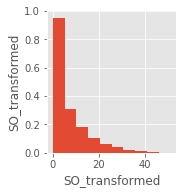

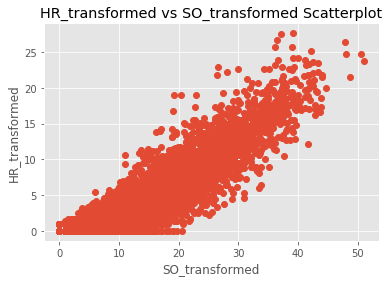

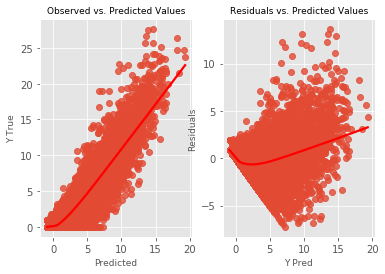

=====Description of Residuals....
count    1.944500e+04
mean     9.396444e-16
std      1.496091e+00
min     -7.239884e+00
25%     -6.533739e-01
50%      1.985465e-01
75%      8.852453e-01
max      1.361846e+01
Name: residuals, dtype: float64


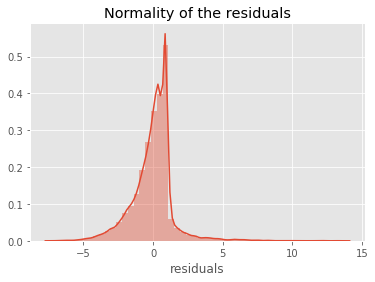

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


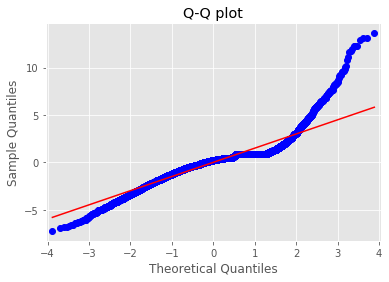

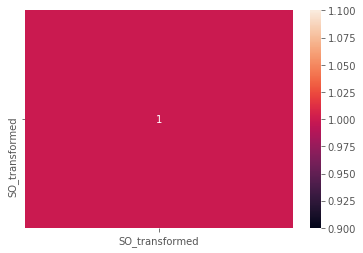

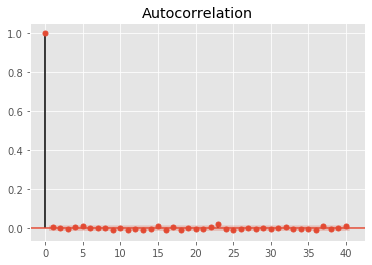

=====Checking autocorrelation
The DurbinWatson coefficient is 1.983982053985345
There is minimal autocorrelation


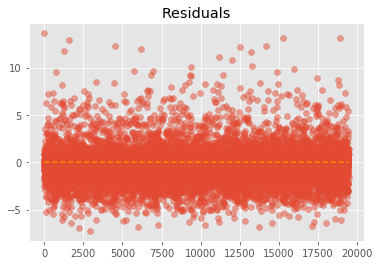

                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 8.699e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:42   Log-Likelihood:                -33067.
No. Observations:               19271   AIC:                         6.614e+04
Df Residuals:                   19269   BIC:                         6.615e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7803      0.013    -60.

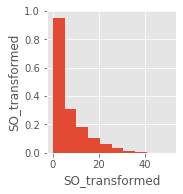

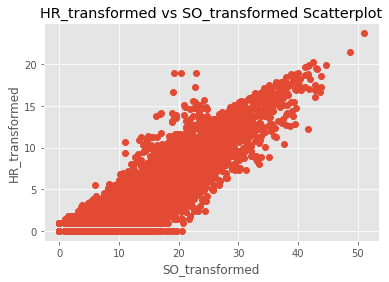

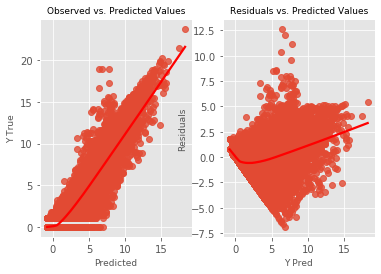

=====Description of Residuals....
count    1.927100e+04
mean     4.031220e-16
std      1.345765e+00
min     -6.879005e+00
25%     -6.180913e-01
50%      1.329706e-01
75%      7.803001e-01
max      1.260107e+01
Name: residuals, dtype: float64


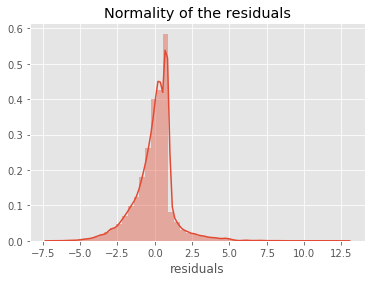

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


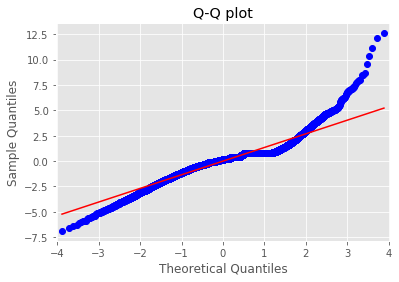

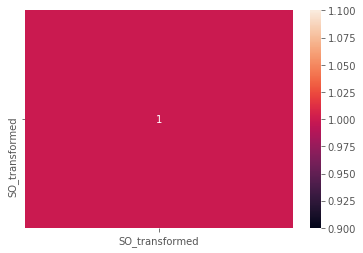

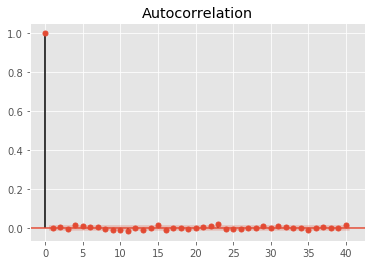

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9975660720795685
There is minimal autocorrelation


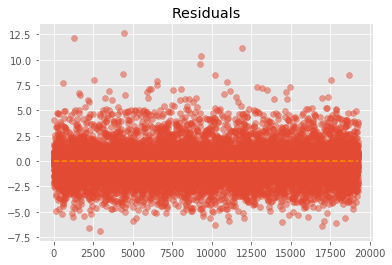

In [28]:
SO_transformed = np.sqrt(df_num['SO'].values)
HR_transformed = np.sqrt(df_num['HR'].values)
df_num['SO_transformed'] = SO_transformed
df_num['HR_transformed'] = HR_transformed

model = ols("HR_transformed ~ SO_transformed", data=df_num).fit()
df_results = pd.DataFrame({'y_true':df_num['HR_transformed'].values,
                           'SO_transformed':df_num['SO_transformed'].values,
                           'y_pred':model.predict(df_num[['SO_transformed']]),
                           'residuals':model.resid.values})
print(model.summary())
check_assumptions(dependent='HR_transformed', independent=['SO_transformed'], results=df_results)

df_OR = identify_outliers(model, df_num)

model_OR = ols("HR_transformed ~ SO_transformed", data=df_OR).fit()
df_results = pd.DataFrame({'y_true':df_OR['HR_transformed'].values,
                            'SO_transformed':df_OR['SO_transformed'].values,
                            'y_pred':model_OR.predict(df_OR[['SO_transformed']]),
                            'residuals':model_OR.resid.values})
print(model_OR.summary())
check_assumptions(dependent='HR_transformed', independent=['SO_transformed'], results=df_results)

# Perform a regression analysis per Era

================================Era1==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     2441.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:45   Log-Likelihood:                -6628.7
No. Observations:                1880   AIC:                         1.326e+04
Df Residuals:                    1878   BIC:                         1.327e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

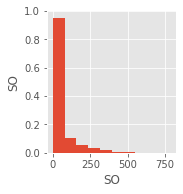

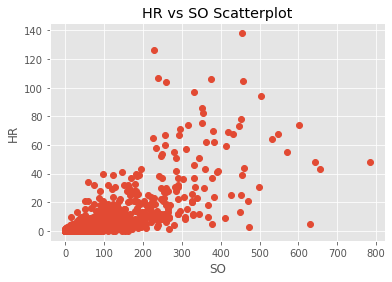

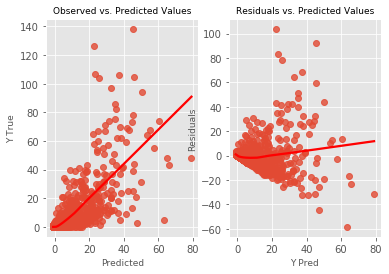

=====Description of Residuals....
count    1.880000e+03
mean    -1.998874e-15
std      8.225366e+00
min     -5.848621e+01
25%     -1.336261e+00
50%      5.465948e-01
75%      9.550976e-01
max      1.035683e+02
Name: residuals, dtype: float64


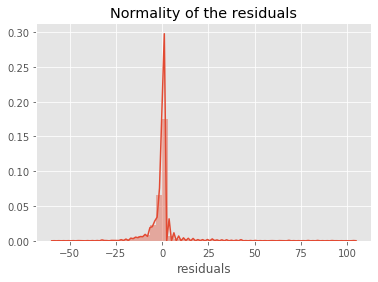

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


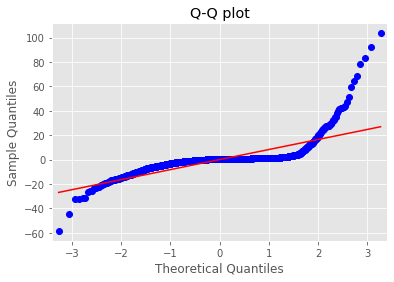

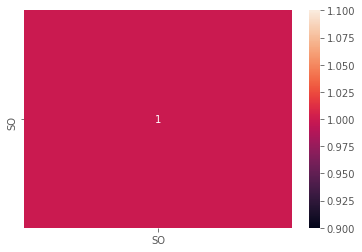

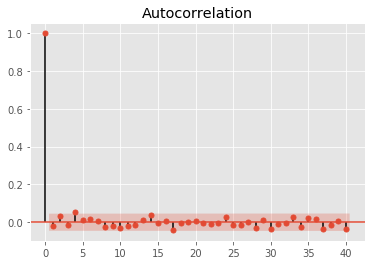

=====Checking autocorrelation
The DurbinWatson coefficient is 2.037310089650988
There is minimal autocorrelation


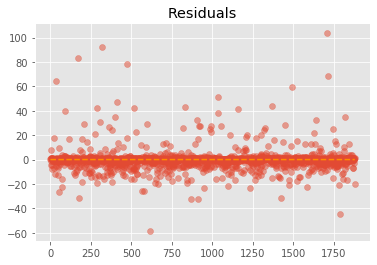

================================Era2==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     3582.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:46   Log-Likelihood:                -8575.7
No. Observations:                2784   AIC:                         1.716e+04
Df Residuals:                    2782   BIC:                         1.717e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

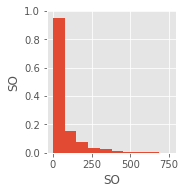

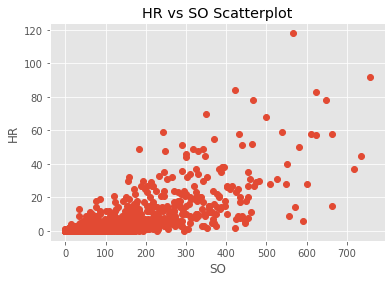

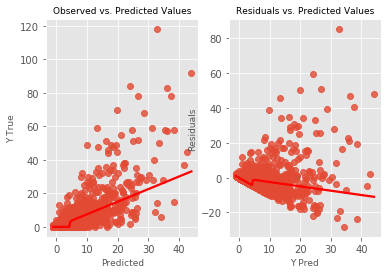

=====Description of Residuals....
count    2.784000e+03
mean     2.322536e-16
std      5.267791e+00
min     -2.828421e+01
25%     -9.623057e-01
50%      6.457017e-01
75%      9.487693e-01
max      8.526581e+01
Name: residuals, dtype: float64


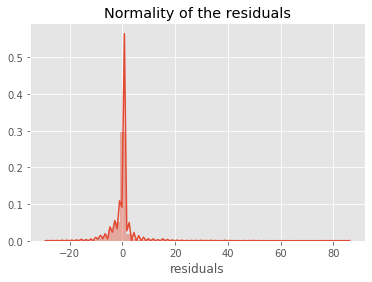

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


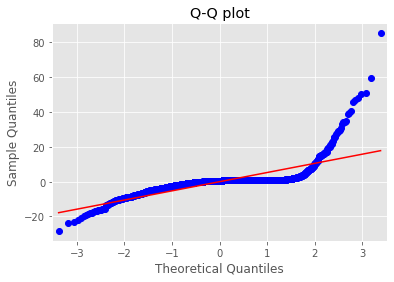

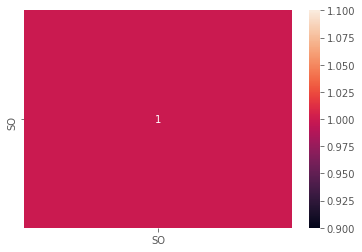

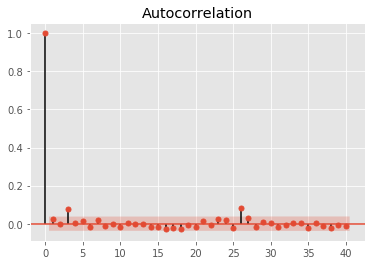

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9425917917498092
There is minimal autocorrelation


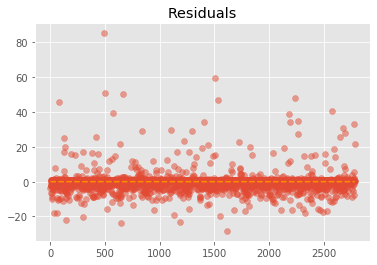

================================Era3==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     4861.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:47   Log-Likelihood:                -13004.
No. Observations:                2943   AIC:                         2.601e+04
Df Residuals:                    2941   BIC:                         2.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

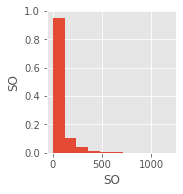

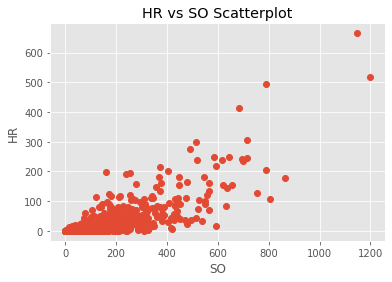

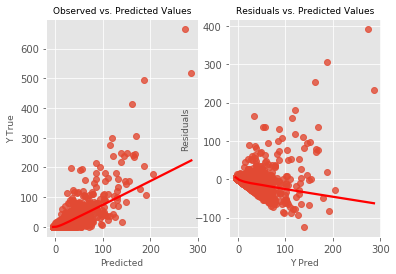

=====Description of Residuals....
count    2.943000e+03
mean    -5.239438e-15
std      2.008295e+01
min     -1.243265e+02
25%     -3.449727e+00
50%      3.340991e+00
75%      4.801750e+00
max      3.910401e+02
Name: residuals, dtype: float64


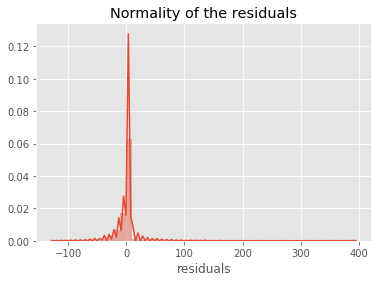

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


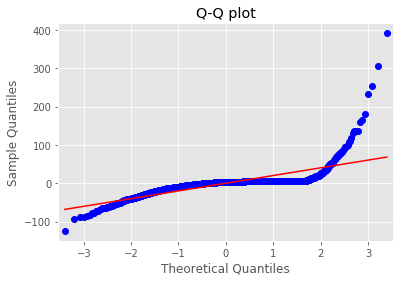

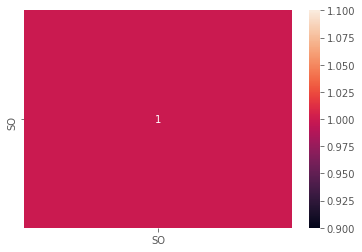

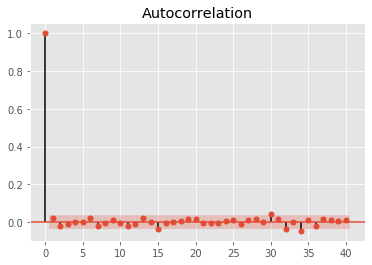

=====Checking autocorrelation
The DurbinWatson coefficient is 1.958572953408873
There is minimal autocorrelation


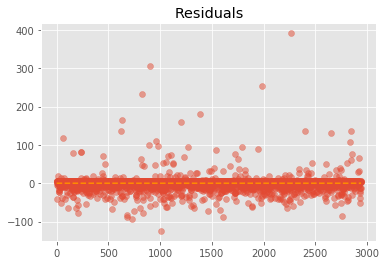

================================Era4==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     6548.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:48   Log-Likelihood:                -12070.
No. Observations:                2734   AIC:                         2.414e+04
Df Residuals:                    2732   BIC:                         2.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

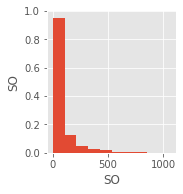

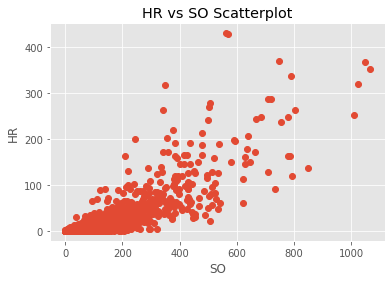

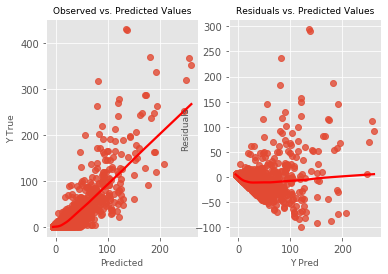

=====Description of Residuals....
count    2.734000e+03
mean    -5.220566e-15
std      2.000921e+01
min     -9.897580e+01
25%     -4.120192e+00
50%      3.196248e+00
75%      5.200444e+00
max      2.942536e+02
Name: residuals, dtype: float64


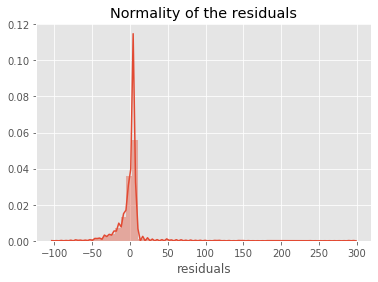

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


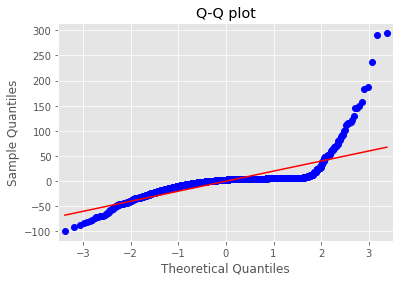

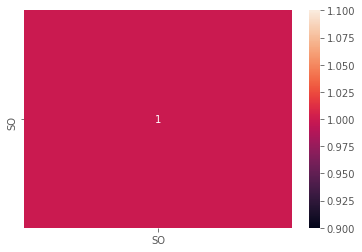

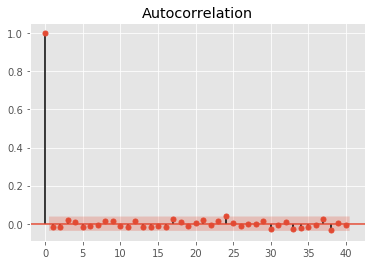

=====Checking autocorrelation
The DurbinWatson coefficient is 2.023300094947454
There is minimal autocorrelation


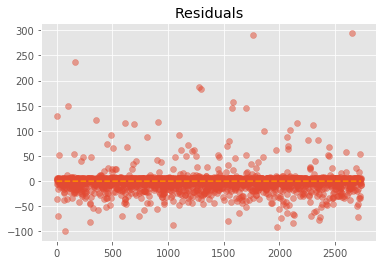

================================Era5==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     8580.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:50   Log-Likelihood:                -11724.
No. Observations:                2598   AIC:                         2.345e+04
Df Residuals:                    2596   BIC:                         2.346e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

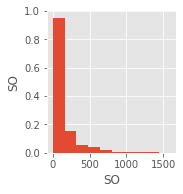

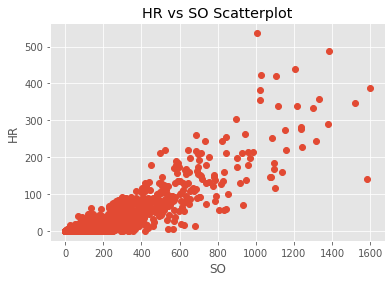

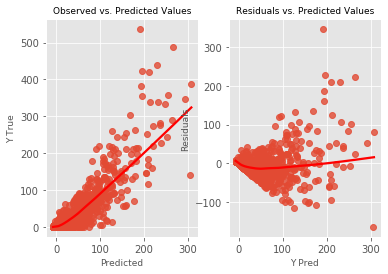

=====Description of Residuals....
count    2.598000e+03
mean     5.994350e-15
std      2.206116e+01
min     -1.630189e+02
25%     -5.163608e+00
50%      4.089969e+00
75%      6.649469e+00
max      3.449773e+02
Name: residuals, dtype: float64


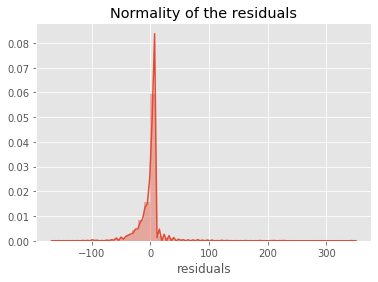

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


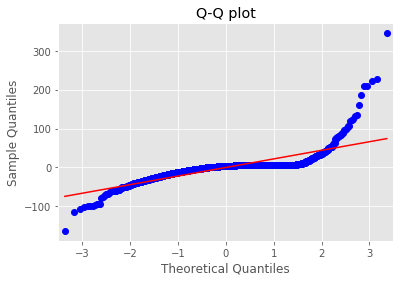

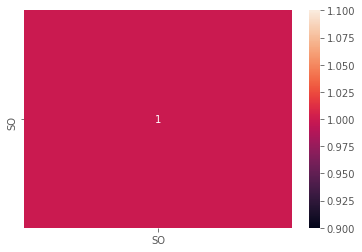

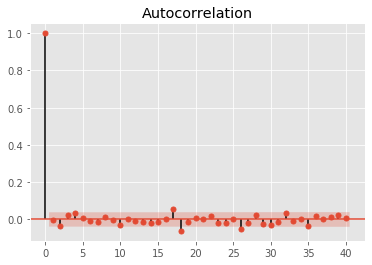

=====Checking autocorrelation
The DurbinWatson coefficient is 1.90949878787855
There is minimal autocorrelation


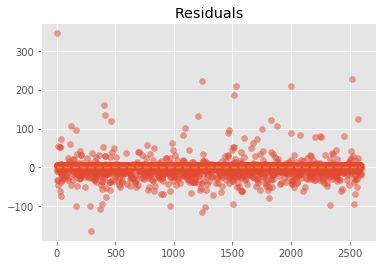

================================Era6==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 1.456e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:51   Log-Likelihood:                -14952.
No. Observations:                3408   AIC:                         2.991e+04
Df Residuals:                    3406   BIC:                         2.992e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

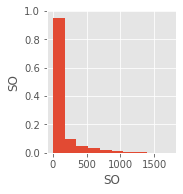

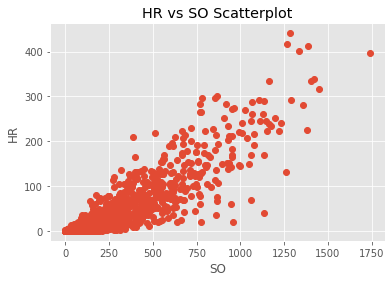

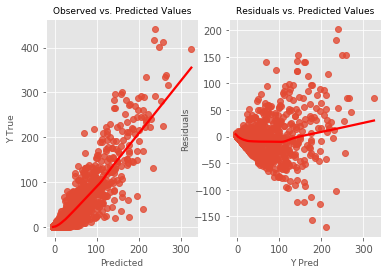

=====Description of Residuals....
count    3.408000e+03
mean    -6.624852e-16
std      1.946096e+01
min     -1.699397e+02
25%     -2.637184e+00
50%      3.238501e+00
75%      4.375730e+00
max      2.018191e+02
Name: residuals, dtype: float64


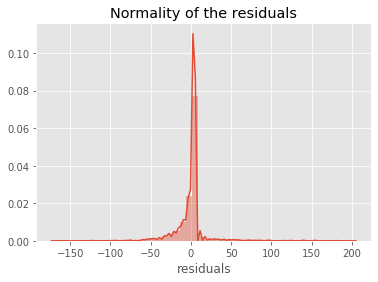

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


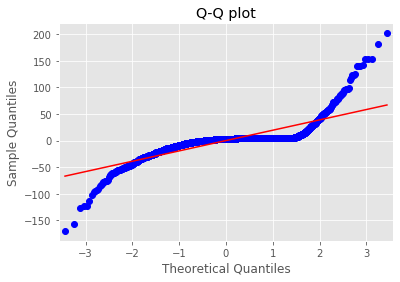

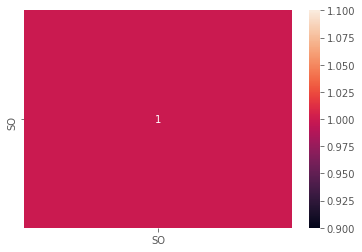

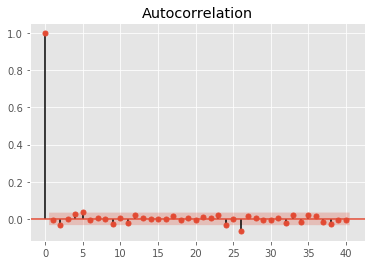

=====Checking autocorrelation
The DurbinWatson coefficient is 2.0078248212702503
There is minimal autocorrelation


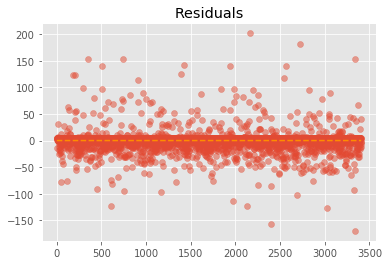

================================Era7==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 1.496e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:52   Log-Likelihood:                -15053.
No. Observations:                3364   AIC:                         3.011e+04
Df Residuals:                    3362   BIC:                         3.012e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

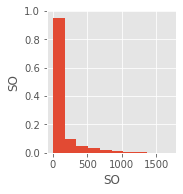

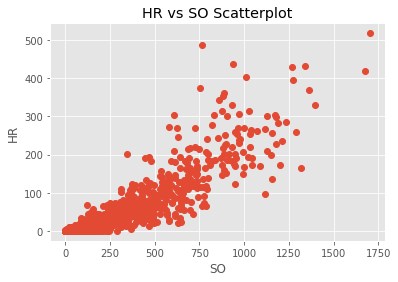

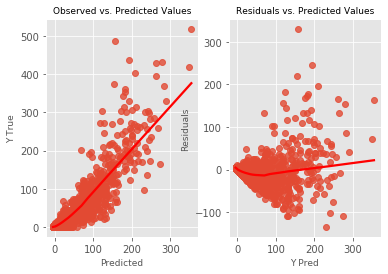

=====Description of Residuals....
count    3.364000e+03
mean    -1.043662e-14
std      2.124434e+01
min     -1.342279e+02
25%     -2.504100e+00
50%      3.629538e+00
75%      4.663735e+00
max      3.291086e+02
Name: residuals, dtype: float64


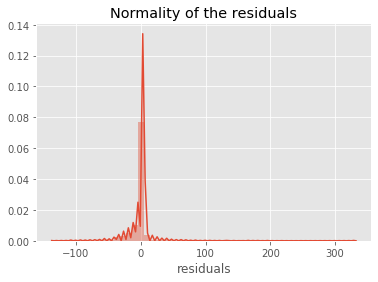

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


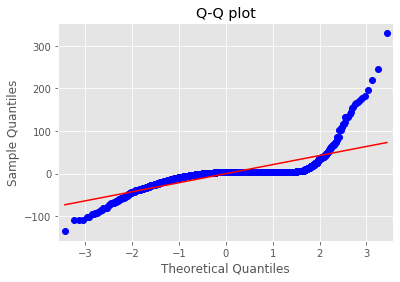

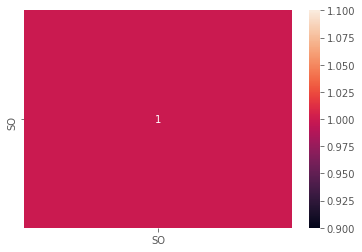

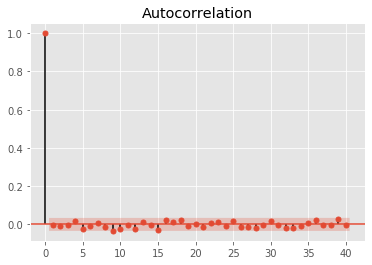

=====Checking autocorrelation
The DurbinWatson coefficient is 2.003140769139985
There is minimal autocorrelation


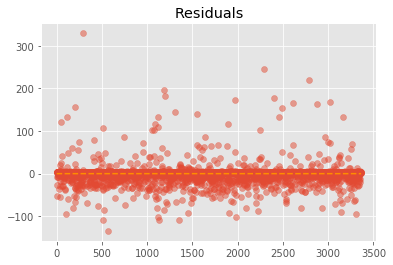

================================Era8==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 2.841e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:54   Log-Likelihood:                -19527.
No. Observations:                4628   AIC:                         3.906e+04
Df Residuals:                    4626   BIC:                         3.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

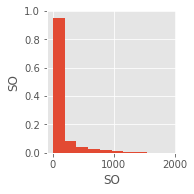

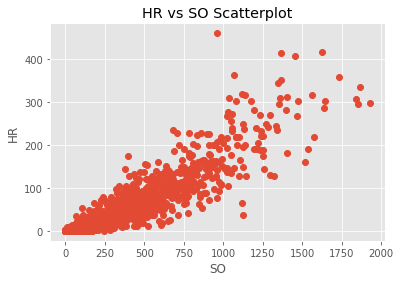

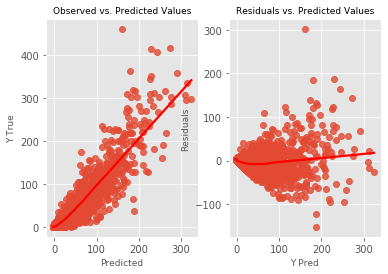

=====Description of Residuals....
count    4.628000e+03
mean     4.654684e-15
std      1.645092e+01
min     -1.518454e+02
25%     -1.543045e+00
50%      2.706551e+00
75%      3.216503e+00
max      3.010320e+02
Name: residuals, dtype: float64


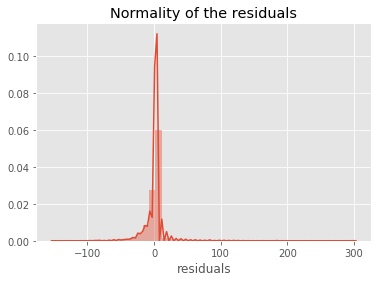

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


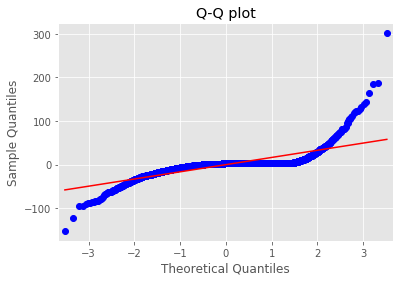

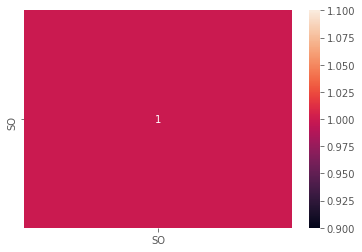

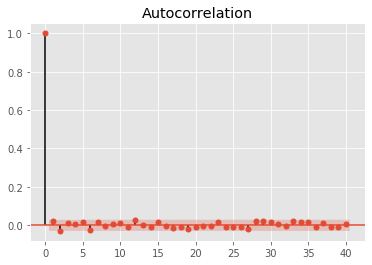

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9568413172852162
There is minimal autocorrelation


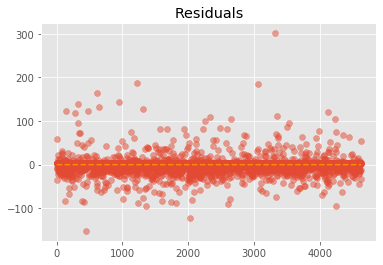

In [29]:
#Create a new df per Era 
aggregation_functions = {'HR': 'sum', 'SO': 'sum'}
era_dfs = {}
for idx in binera_labels:
    era_dfs[idx] = df.loc[df['eraID'] == idx]
    era_dfs[idx].reset_index(drop=True, inplace=True)
    era_dfs[idx] = era_dfs[idx].groupby(era_dfs[idx]['playerID'], as_index=False).aggregate(aggregation_functions)
    

#Evaluate the regression analysis, per Era
for key, value in era_dfs.items():
    model = ols("HR ~ SO", data=value).fit()
    df_results = pd.DataFrame({'y_true':value['HR'].values,
                               'SO':value['SO'].values,
                               'y_pred':model.predict(value[['SO']]),
                               'residuals':model.resid.values})
    
    print(f'================================{key}==========================================')
    print(model.summary())
    check_assumptions(dependent='HR', independent=['SO'], results=df_results)

# Perform a regression analysis per Era, outliers removed

================================Era1==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2645.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:56   Log-Likelihood:                -5913.1
No. Observations:                1850   AIC:                         1.183e+04
Df Residuals:                    1848   BIC:                         1.184e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

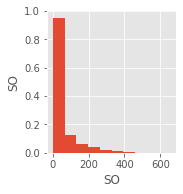

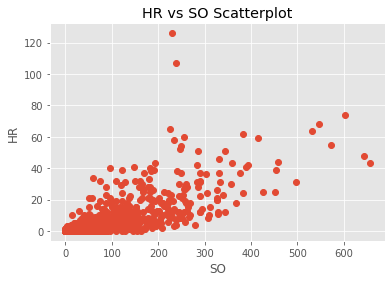

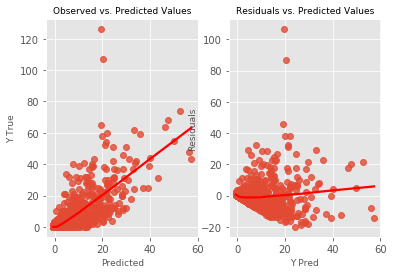

=====Description of Residuals....
count    1.850000e+03
mean    -1.732548e-16
std      5.915643e+00
min     -2.001301e+01
25%     -1.105505e+00
50%      3.096297e-01
75%      6.634135e-01
max      1.064093e+02
Name: residuals, dtype: float64


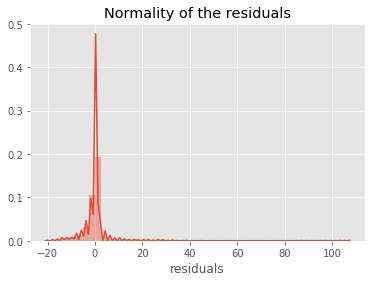

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


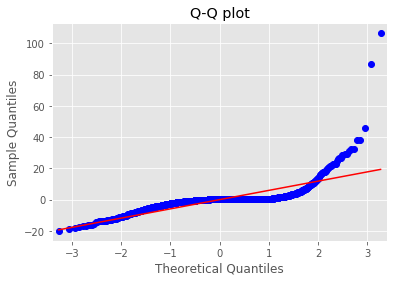

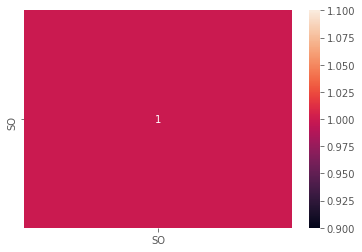

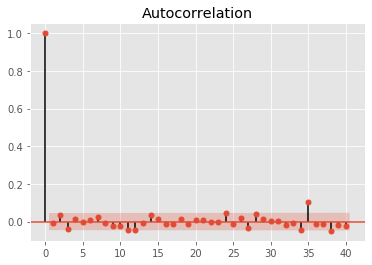

=====Checking autocorrelation
The DurbinWatson coefficient is 2.0099982627726156
There is minimal autocorrelation


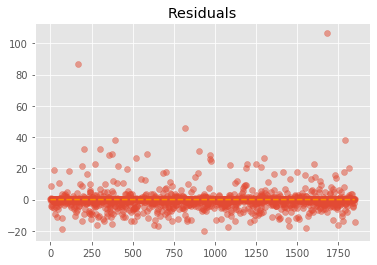

================================Era2==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     4139.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:02:59   Log-Likelihood:                -7184.1
No. Observations:                2738   AIC:                         1.437e+04
Df Residuals:                    2736   BIC:                         1.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

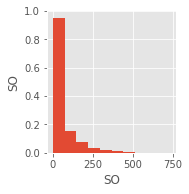

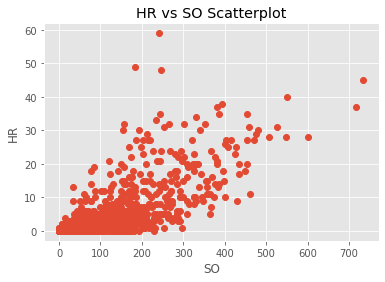

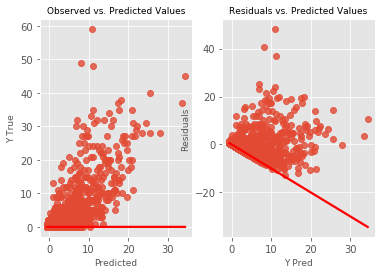

=====Description of Residuals....
count    2.738000e+03
mean     4.191112e-16
std      3.337021e+00
min     -1.254671e+01
25%     -7.463381e-01
50%      3.479193e-01
75%      5.858409e-01
max      4.807043e+01
Name: residuals, dtype: float64


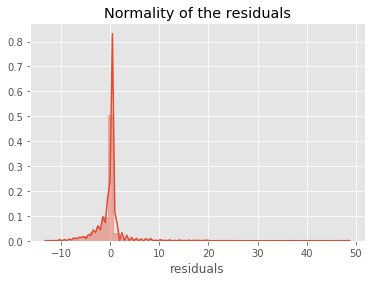

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


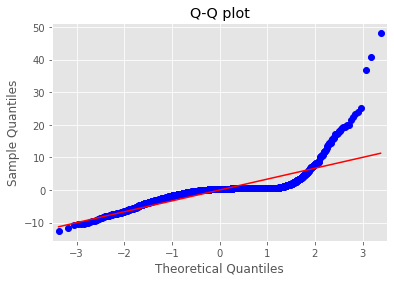

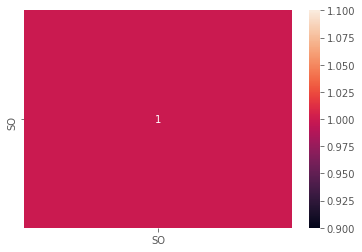

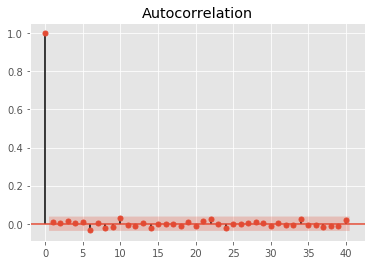

=====Checking autocorrelation
The DurbinWatson coefficient is 1.966589483838497
There is minimal autocorrelation


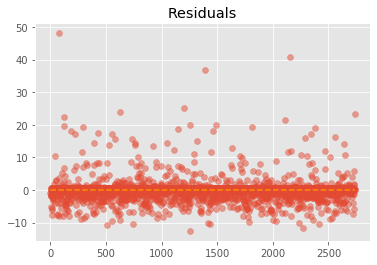

================================Era3==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4972.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:01   Log-Likelihood:                -11376.
No. Observations:                2903   AIC:                         2.276e+04
Df Residuals:                    2901   BIC:                         2.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

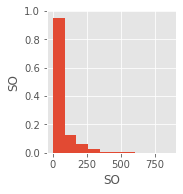

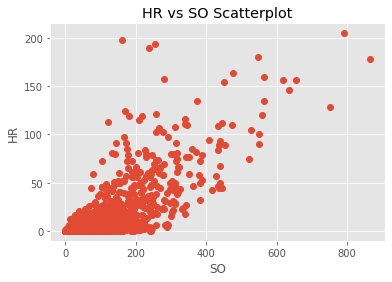

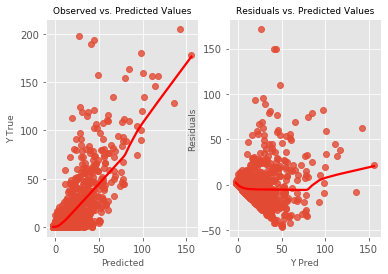

=====Description of Residuals....
count    2.903000e+03
mean    -2.386425e-16
std      1.218129e+01
min     -4.612246e+01
25%     -2.613987e+00
50%      1.604912e+00
75%      2.338634e+00
max      1.711732e+02
Name: residuals, dtype: float64


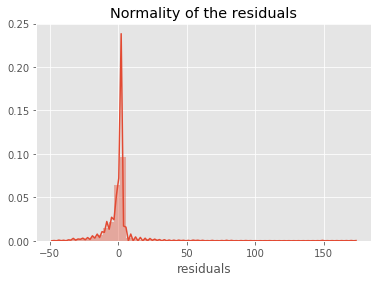

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


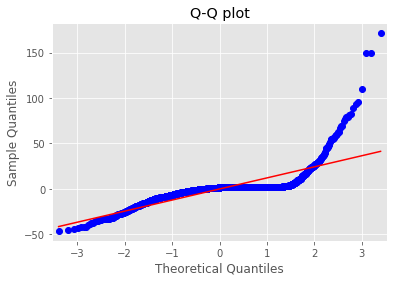

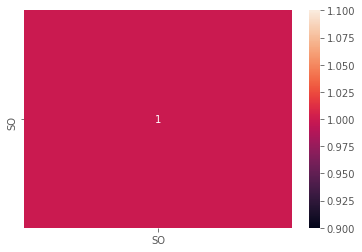

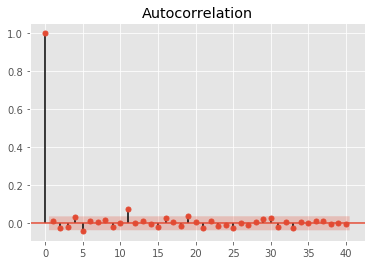

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9752720109070598
There is minimal autocorrelation


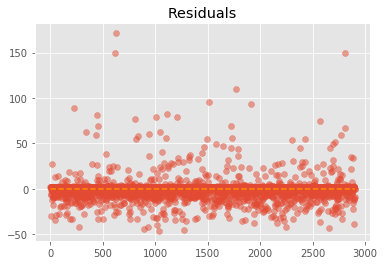

================================Era4==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     7886.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:04   Log-Likelihood:                -10695.
No. Observations:                2690   AIC:                         2.139e+04
Df Residuals:                    2688   BIC:                         2.141e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

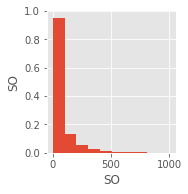

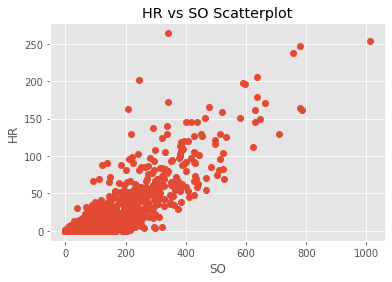

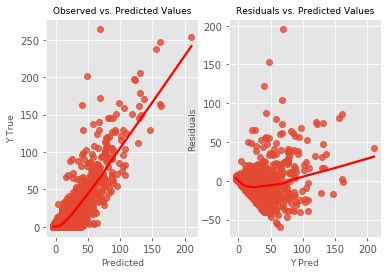

=====Description of Residuals....
count    2.690000e+03
mean    -1.042702e-15
std      1.289669e+01
min     -5.936988e+01
25%     -3.132086e+00
50%      2.165301e+00
75%      3.648569e+00
max      1.953922e+02
Name: residuals, dtype: float64


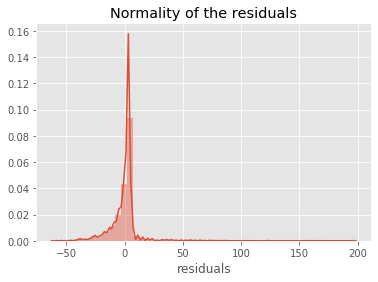

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


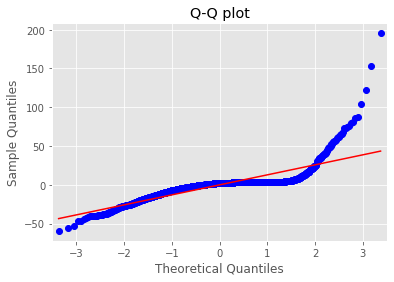

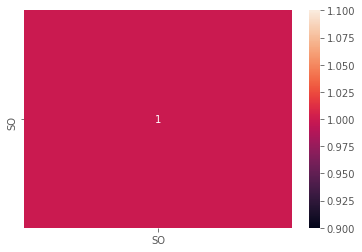

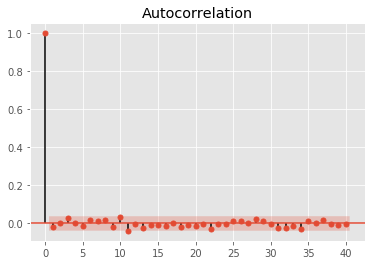

=====Checking autocorrelation
The DurbinWatson coefficient is 2.0335568425096744
There is minimal autocorrelation


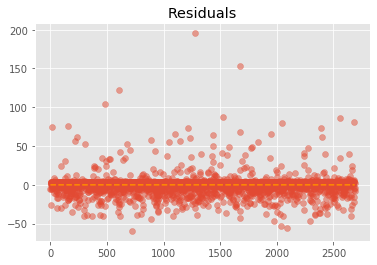

================================Era5==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:06   Log-Likelihood:                -10518.
No. Observations:                2562   AIC:                         2.104e+04
Df Residuals:                    2560   BIC:                         2.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

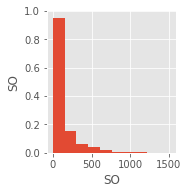

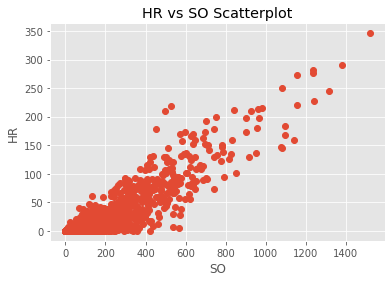

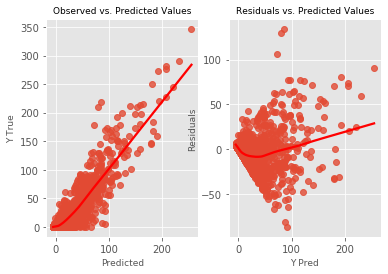

=====Description of Residuals....
count    2.562000e+03
mean    -5.337044e-15
std      1.468473e+01
min     -8.706874e+01
25%     -4.121192e+00
50%      2.894080e+00
75%      4.776226e+00
max      1.339465e+02
Name: residuals, dtype: float64


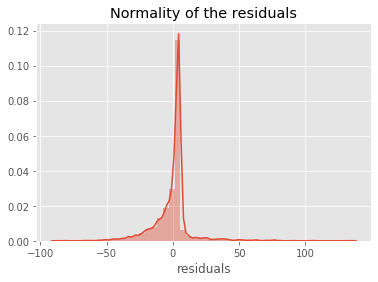

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


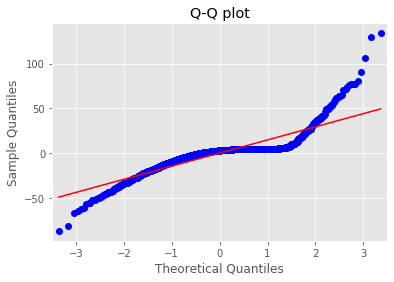

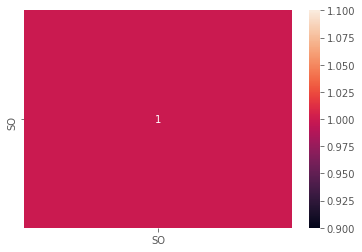

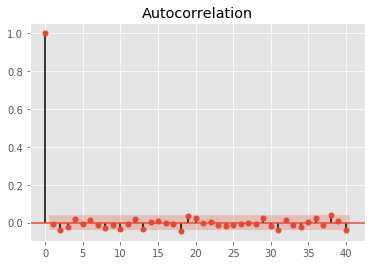

=====Checking autocorrelation
The DurbinWatson coefficient is 2.009723536381964
There is minimal autocorrelation


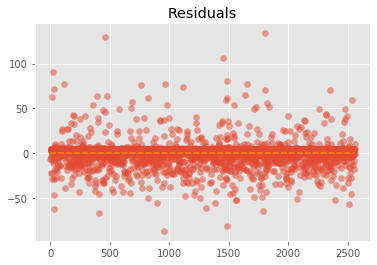

================================Era6==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 1.825e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:09   Log-Likelihood:                -13556.
No. Observations:                3353   AIC:                         2.712e+04
Df Residuals:                    3351   BIC:                         2.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

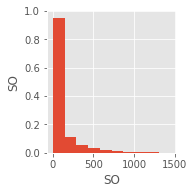

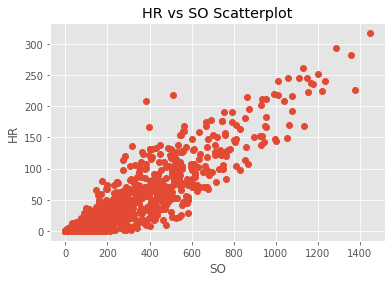

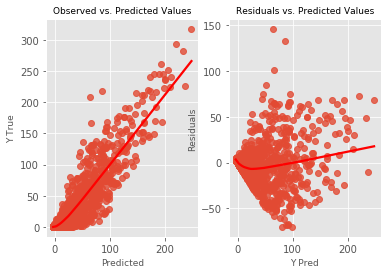

=====Description of Residuals....
count    3.353000e+03
mean     8.436768e-16
std      1.379256e+01
min     -7.014306e+01
25%     -2.176465e+00
50%      2.517553e+00
75%      3.386816e+00
max      1.454536e+02
Name: residuals, dtype: float64


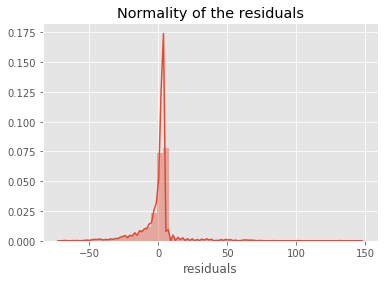

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


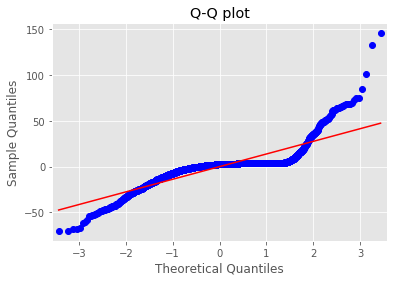

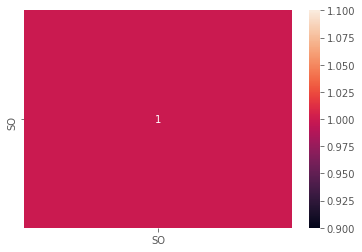

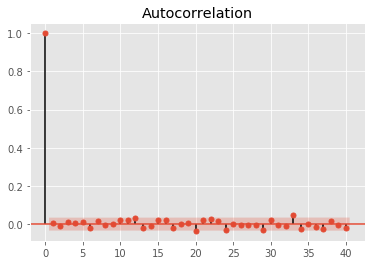

=====Checking autocorrelation
The DurbinWatson coefficient is 1.992000689325677
There is minimal autocorrelation


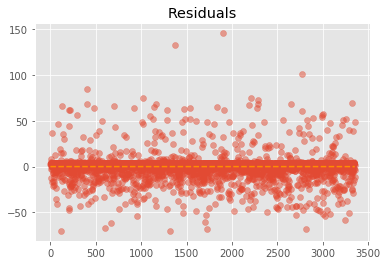

================================Era7==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 2.307e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:13   Log-Likelihood:                -13260.
No. Observations:                3306   AIC:                         2.652e+04
Df Residuals:                    3304   BIC:                         2.654e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

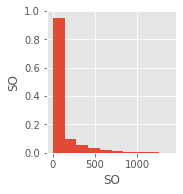

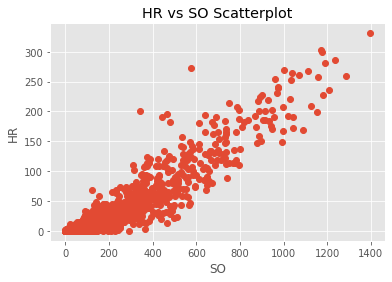

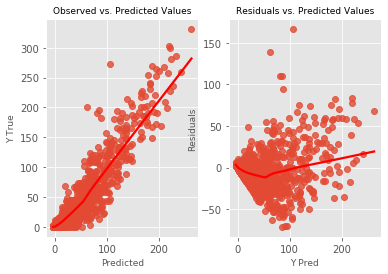

=====Description of Residuals....
count    3.306000e+03
mean    -4.639295e-15
std      1.335632e+01
min     -7.137158e+01
25%     -1.678429e+00
50%      2.745668e+00
75%      3.508587e+00
max      1.664574e+02
Name: residuals, dtype: float64


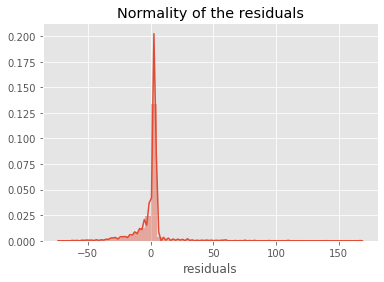

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


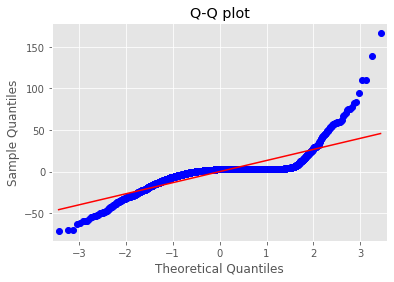

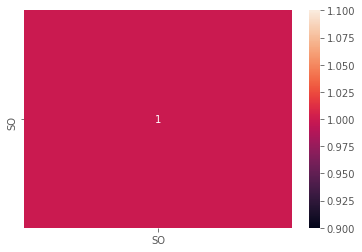

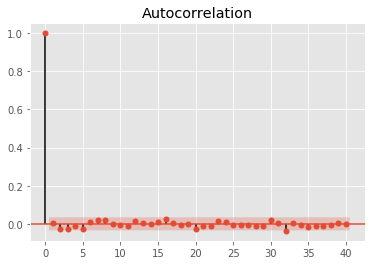

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9871454815339624
There is minimal autocorrelation


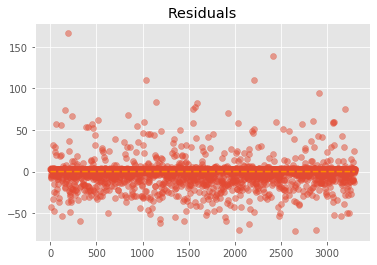

================================Era8==========================================
                            OLS Regression Results                            
Dep. Variable:                     HR   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 4.128e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:17   Log-Likelihood:                -17323.
No. Observations:                4551   AIC:                         3.465e+04
Df Residuals:                    4549   BIC:                         3.466e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

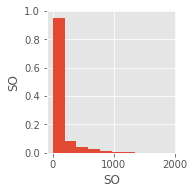

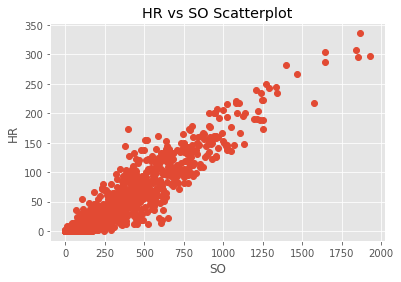

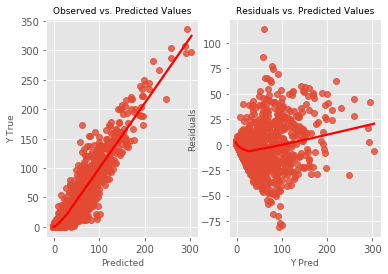

=====Description of Residuals....
count    4.551000e+03
mean    -1.277135e-15
std      1.088603e+01
min     -8.071155e+01
25%     -1.260630e+00
50%      2.240094e+00
75%      2.558341e+00
max      1.135453e+02
Name: residuals, dtype: float64


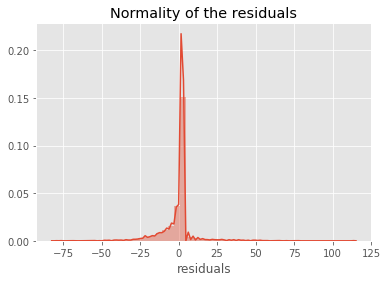

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


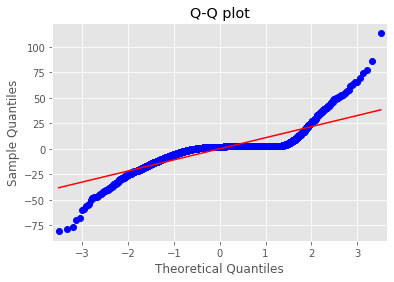

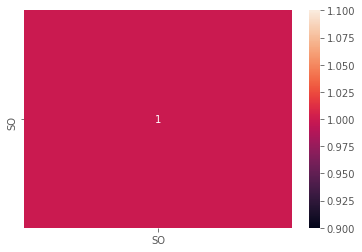

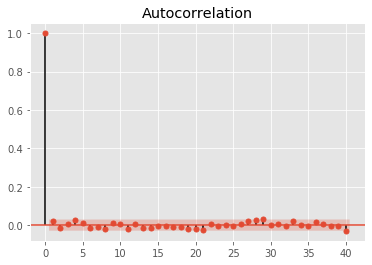

=====Checking autocorrelation
The DurbinWatson coefficient is 1.96160656118806
There is minimal autocorrelation


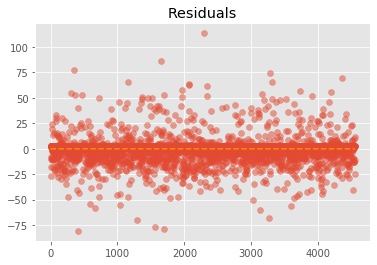

In [30]:
for key, value in era_dfs.items():
    model = ols("HR ~ SO", data=value).fit()
    df_OR = identify_outliers(model, value)
    
    model_OR = ols("HR ~ SO", data=df_OR).fit()
    df_results = pd.DataFrame({'y_true':df_OR['HR'].values,
                               'SO':df_OR['SO'].values,
                               'y_pred':model_OR.predict(df_OR[['SO']]),
                               'residuals':model_OR.resid.values})
    
    print(f'================================{key}==========================================')
    print(model_OR.summary())
    check_assumptions(dependent='HR', independent=['SO'], results=df_results)

# Perform a regression analysis per Era, attempted transform

==========================Transformed Era1====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     4338.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:19   Log-Likelihood:                -2652.4
No. Observations:                1880   AIC:                             5309.
Df Residuals:                    1878   BIC:                             5320.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

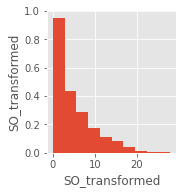

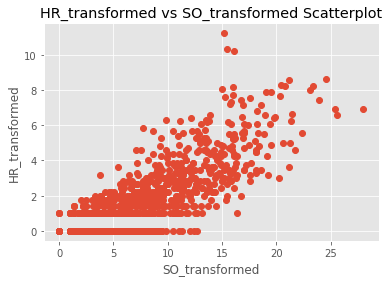

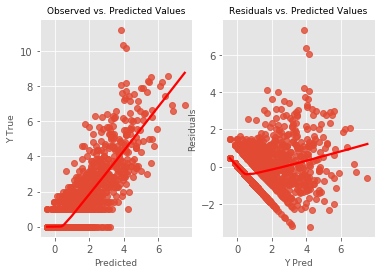

=====Description of Residuals....
count    1.864000e+03
mean     2.830056e-16
std      9.183568e-01
min     -3.225996e+00
25%     -4.521329e-01
50%      4.731747e-02
75%      4.513813e-01
max      7.352681e+00
Name: residuals, dtype: float64


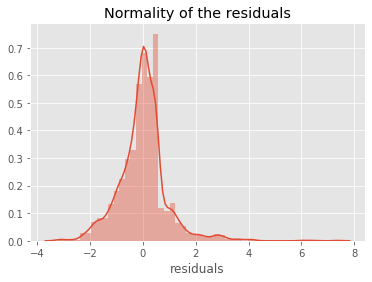

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


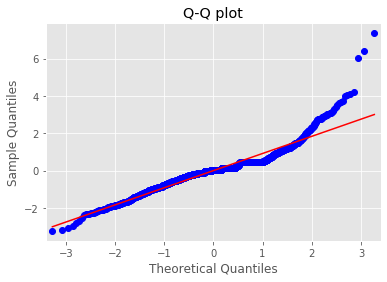

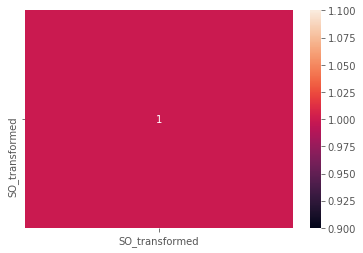

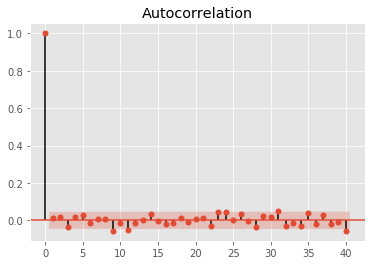

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9762355384559513
There is minimal autocorrelation


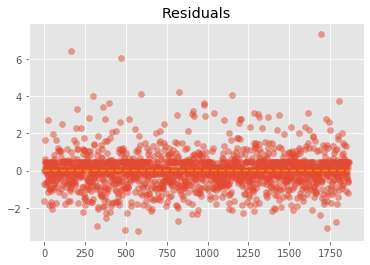

==========================Transformed Era2====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     5382.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:21   Log-Likelihood:                -3398.2
No. Observations:                2784   AIC:                             6800.
Df Residuals:                    2782   BIC:                             6812.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

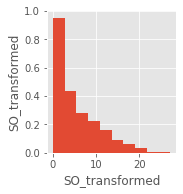

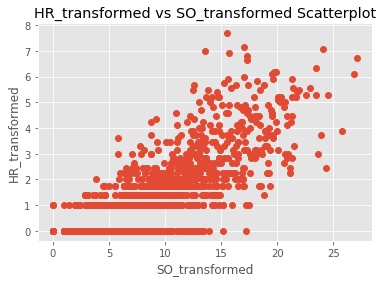

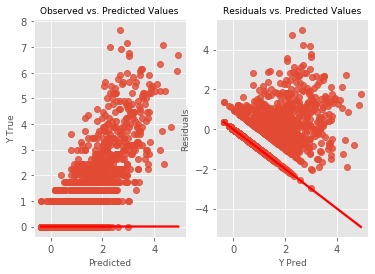

=====Description of Residuals....
count    2.761000e+03
mean     1.230454e-16
std      7.433175e-01
min     -2.985400e+00
25%     -3.487255e-01
50%      2.713270e-02
75%      3.650002e-01
max      5.011602e+00
Name: residuals, dtype: float64


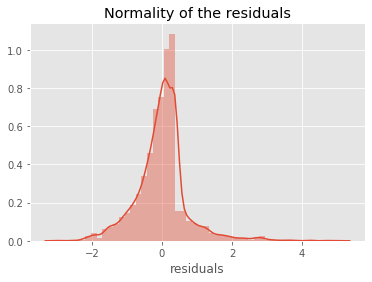

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


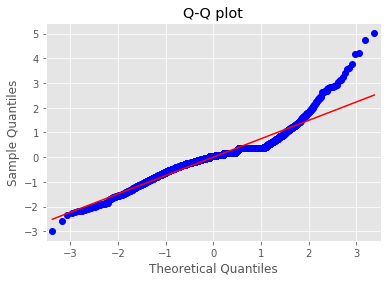

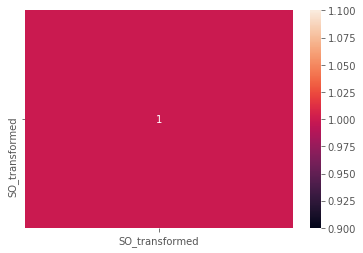

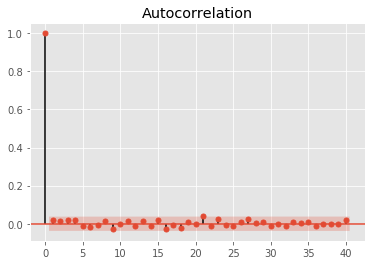

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9562801562981644
There is minimal autocorrelation


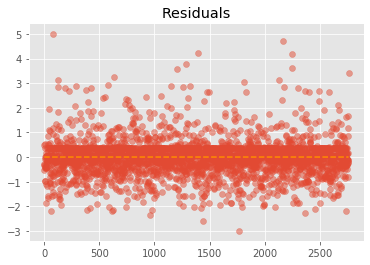

==========================Transformed Era3====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     6783.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:23   Log-Likelihood:                -5277.4
No. Observations:                2943   AIC:                         1.056e+04
Df Residuals:                    2941   BIC:                         1.057e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

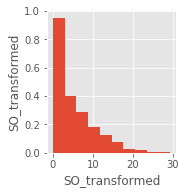

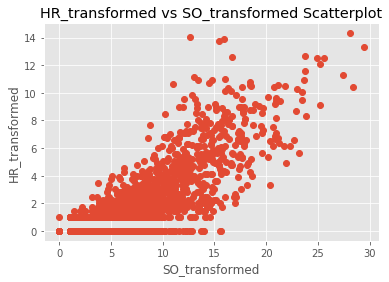

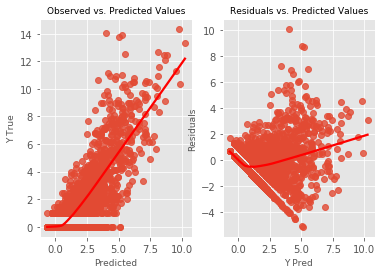

=====Description of Residuals....
count    2.914000e+03
mean     4.205436e-16
std      1.270228e+00
min     -5.129664e+00
25%     -5.737560e-01
50%      4.045170e-02
75%      6.575384e-01
max      1.003281e+01
Name: residuals, dtype: float64


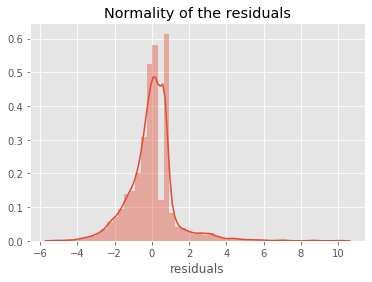

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


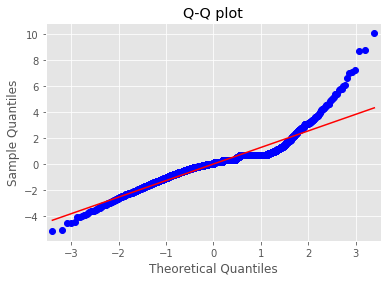

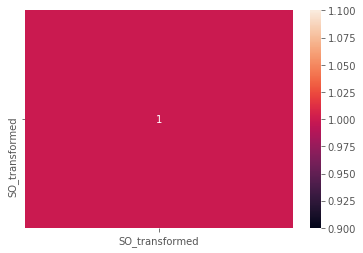

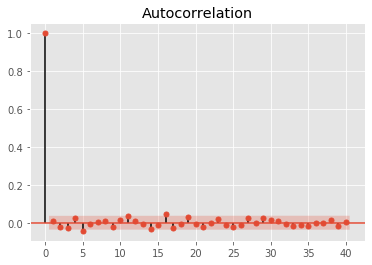

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9776830304466049
There is minimal autocorrelation


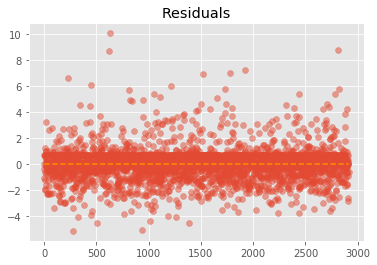

==========================Transformed Era4====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     8457.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:26   Log-Likelihood:                -4967.9
No. Observations:                2734   AIC:                             9940.
Df Residuals:                    2732   BIC:                             9952.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

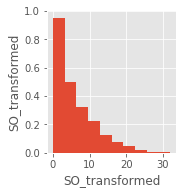

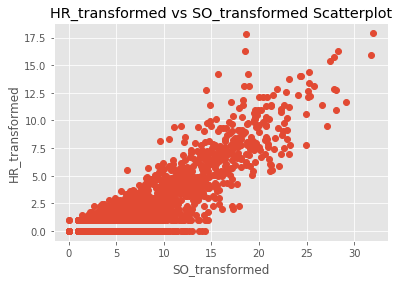

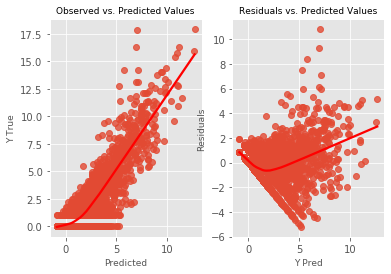

=====Description of Residuals....
count    2.711000e+03
mean    -7.289550e-17
std      1.364157e+00
min     -5.204159e+00
25%     -6.953690e-01
50%      1.522826e-01
75%      8.873977e-01
max      1.080252e+01
Name: residuals, dtype: float64


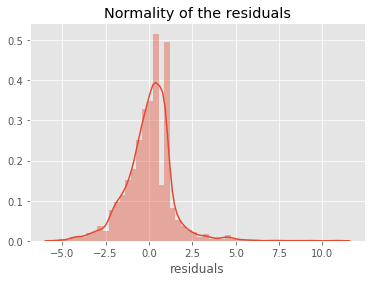

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


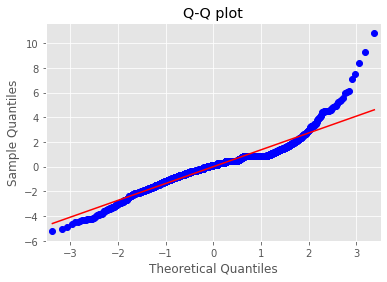

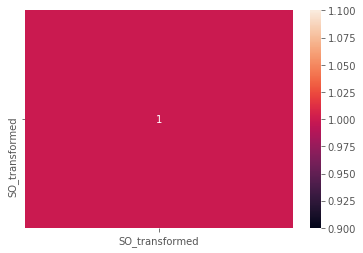

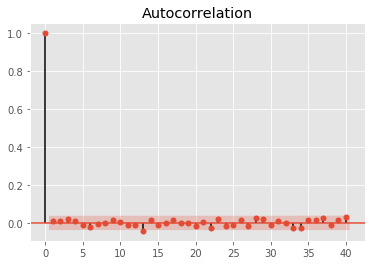

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9822640252158557
There is minimal autocorrelation


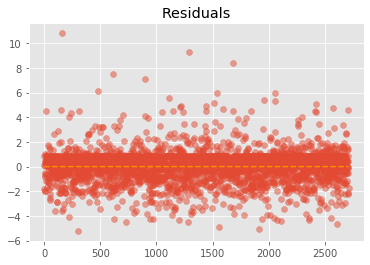

==========================Transformed Era5====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     9800.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:29   Log-Likelihood:                -4881.4
No. Observations:                2598   AIC:                             9767.
Df Residuals:                    2596   BIC:                             9778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

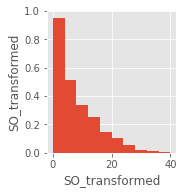

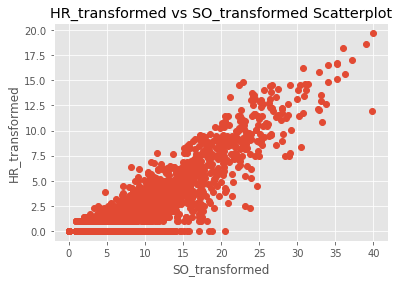

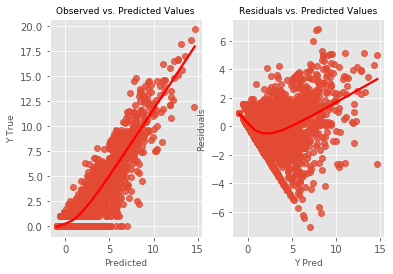

=====Description of Residuals....
count    2.579000e+03
mean    -3.224339e-16
std      1.475273e+00
min     -7.045222e+00
25%     -6.909282e-01
50%      1.820588e-01
75%      9.636441e-01
max      6.799584e+00
Name: residuals, dtype: float64


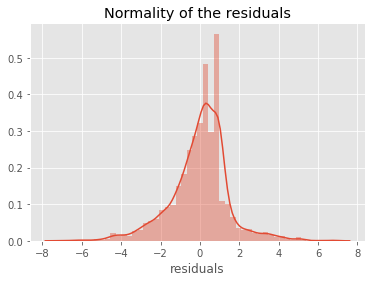

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


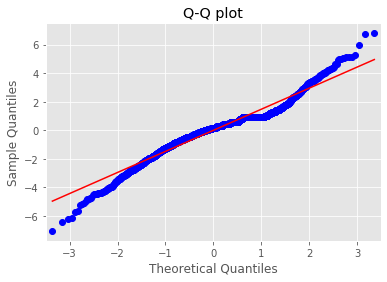

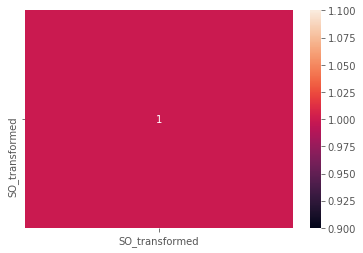

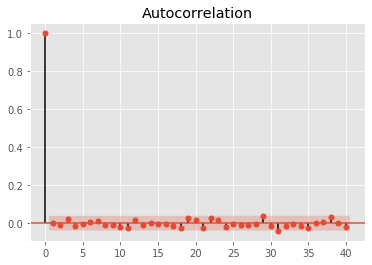

=====Checking autocorrelation
The DurbinWatson coefficient is 1.9950707638447231
There is minimal autocorrelation


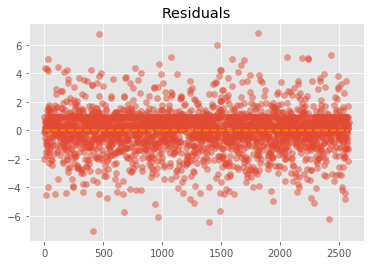

==========================Transformed Era6====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 1.849e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:31   Log-Likelihood:                -5935.1
No. Observations:                3408   AIC:                         1.187e+04
Df Residuals:                    3406   BIC:                         1.189e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

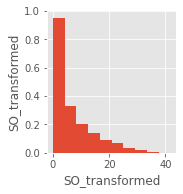

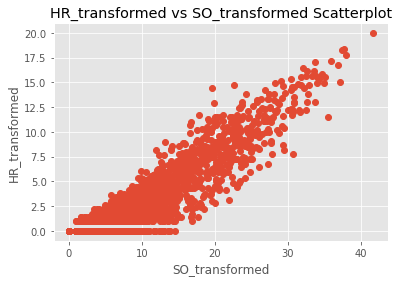

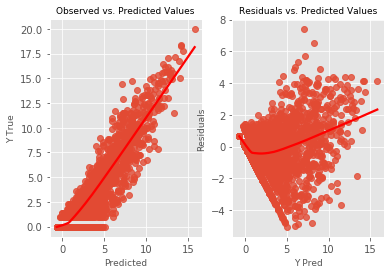

=====Description of Residuals....
count    3.376000e+03
mean    -3.207019e-16
std      1.279059e+00
min     -5.047070e+00
25%     -5.820110e-01
50%      1.563179e-01
75%      6.894737e-01
max      7.378989e+00
Name: residuals, dtype: float64


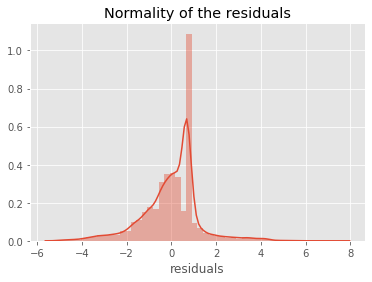

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


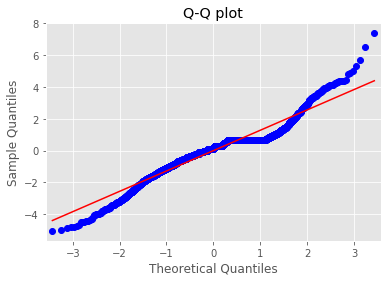

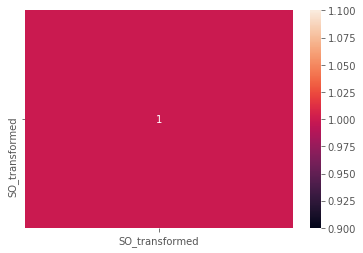

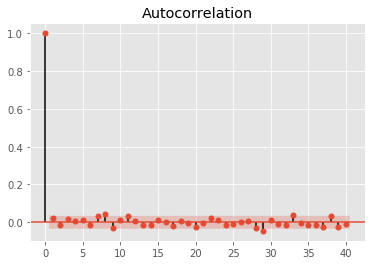

=====Checking autocorrelation
The DurbinWatson coefficient is 1.952159390291414
There is minimal autocorrelation


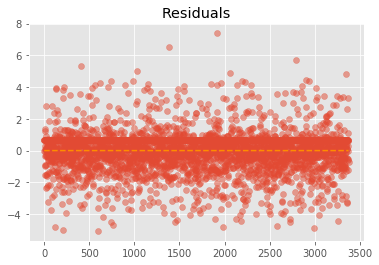

==========================Transformed Era7====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 2.252e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:35   Log-Likelihood:                -5695.7
No. Observations:                3364   AIC:                         1.140e+04
Df Residuals:                    3362   BIC:                         1.141e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

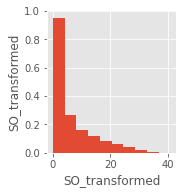

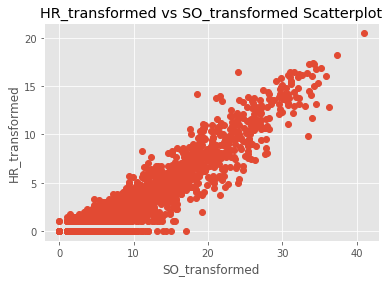

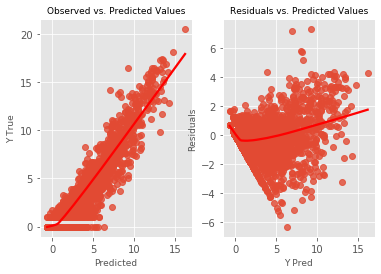

=====Description of Residuals....
count    3.332000e+03
mean    -7.351729e-16
std      1.176350e+00
min     -6.348336e+00
25%     -5.040755e-01
50%      1.866101e-01
75%      6.599348e-01
max      7.297121e+00
Name: residuals, dtype: float64


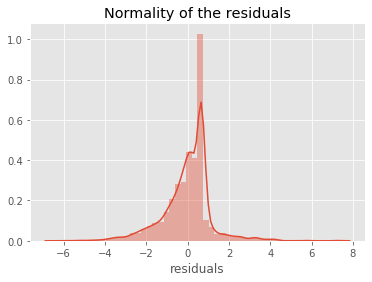

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


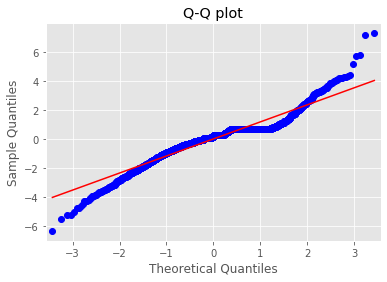

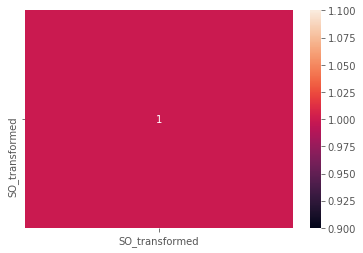

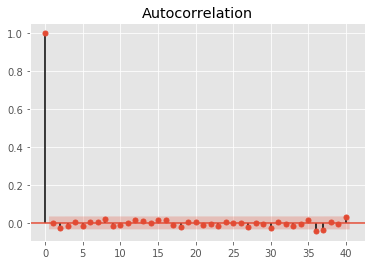

=====Checking autocorrelation
The DurbinWatson coefficient is 2.0011642895867072
There is minimal autocorrelation


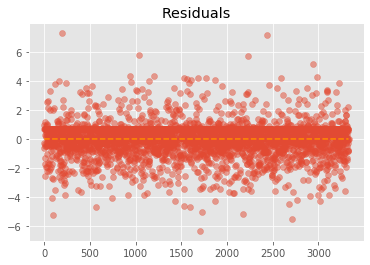

==========================Transformed Era8====================================
                            OLS Regression Results                            
Dep. Variable:         HR_transformed   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 3.745e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:03:38   Log-Likelihood:                -7251.2
No. Observations:                4628   AIC:                         1.451e+04
Df Residuals:                    4626   BIC:                         1.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

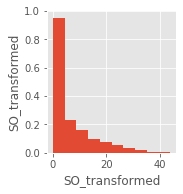

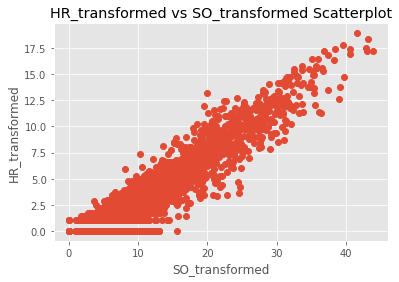

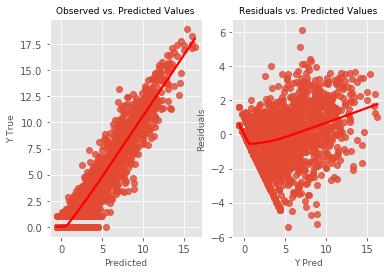

=====Description of Residuals....
count    4.591000e+03
mean    -4.273549e-16
std      1.073505e+00
min     -5.406114e+00
25%     -5.047020e-01
50%      1.958783e-01
75%      5.790384e-01
max      6.145154e+00
Name: residuals, dtype: float64


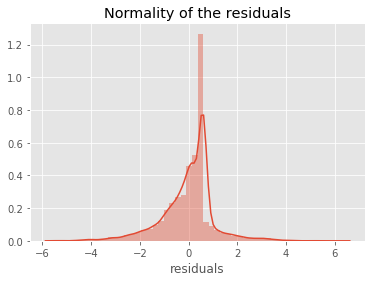

=====Normality check of residuals
The p-value for the Ander-Darling test is 0.0
Residuals are not normally distributed


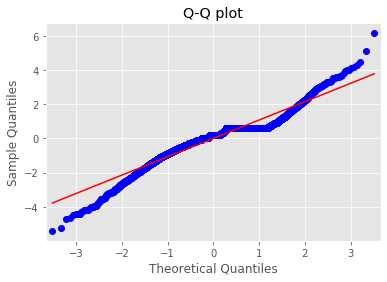

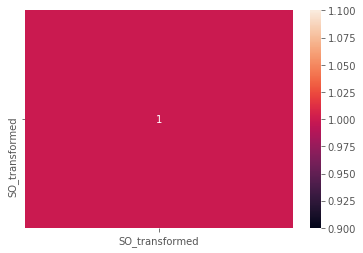

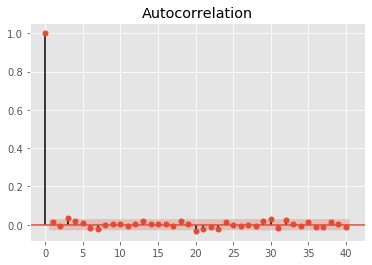

=====Checking autocorrelation
The DurbinWatson coefficient is 1.966647734222602
There is minimal autocorrelation


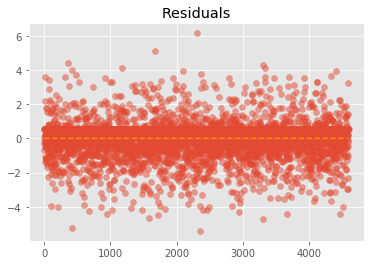

In [31]:
for key, value in era_dfs.items():
    SO_transformed = np.sqrt(value['SO'].values)
    HR_transformed = np.sqrt(value['HR'].values)
    value['SO_transformed'] = SO_transformed
    value['HR_transformed'] = HR_transformed
    
    model = ols("HR_transformed ~ SO_transformed", data=value).fit()
    print(f'==========================Transformed {key}====================================')
    print(model.summary())
    
    df_OR = identify_outliers(model, value)
    model_OR = ols("HR_transformed ~ SO_transformed", data=df_OR).fit()
    df_results = pd.DataFrame({'y_true':df_OR['HR_transformed'].values,
                               'SO_transformed':df_OR['SO_transformed'].values,
                               'y_pred':model_OR.predict(df_OR[['SO_transformed']]),
                               'residuals':model_OR.resid.values})
    
    print(f'=================Transformed & outliers removed{key}===========================')
    print(model_OR.summary())
    check_assumptions(dependent='HR_transformed', independent=['SO_transformed'], results=df_results)

# Further evaluate the dependent and independent variables

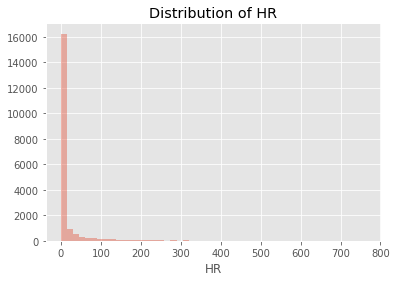

In [32]:
sns.distplot(df_num['HR'], kde=False)
plt.title('Distribution of HR')
plt.show()

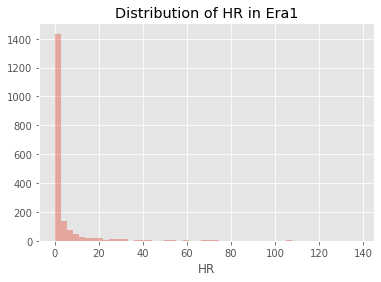

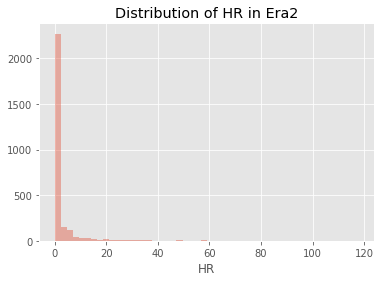

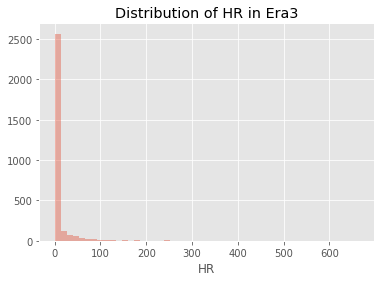

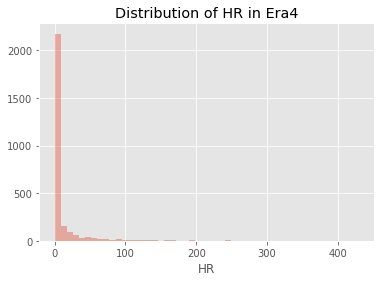

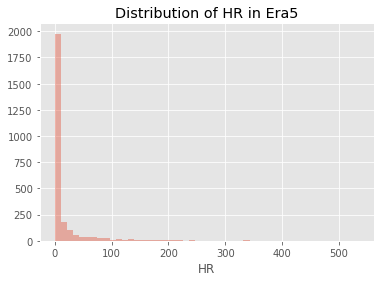

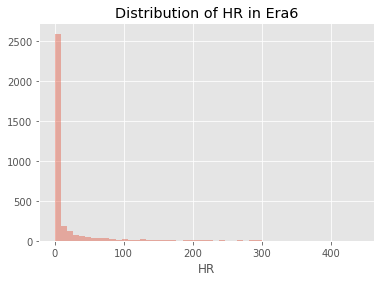

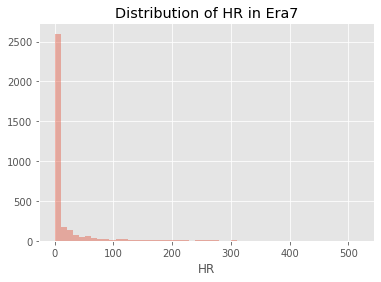

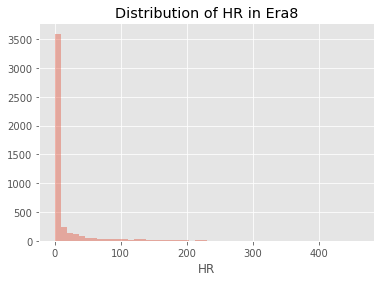

In [33]:
for key, value in era_dfs.items():
    sns.distplot(value['HR'], kde=False)
    plt.title(f'Distribution of HR in {key}')
    plt.show()

In both the HR and SO distirbutions we see there are far more zeros than expected

In [36]:
from patsy import dmatrices

expr = "HR ~ SO"
y, X = dmatrices(expr, df_num, return_type='dataframe')

ZIP = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit').fit(maxiter=100)
print(ZIP.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 15.460985
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                      HR   No. Observations:                19445
Model:             ZeroInflatedPoisson   Df Residuals:                    19443
Method:                            MLE   Df Model:                            1
Date:                 Wed, 08 Dec 2021   Pseudo R-squ.:                  0.1531
Time:                         12:14:03   Log-Likelihood:            -3.0064e+05
converged:                       False   LL-Null:                   -3.5499e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     0.1000      0.024      4.181     

In [40]:
import statsmodels.formula.api as smf
from scipy.stats.distributions import chi2

expr = "HR ~ SO"
y, X = dmatrices(expr, df_num, return_type='dataframe')
poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit()
df_num['HR_LAMBDA'] = poisson.mu
df_num['AUX_OLS_DEP'] = df_num.apply(lambda x: ((x['HR'] - x['HR_LAMBDA'])**2 - x['HR_LAMBDA']) / x['HR_LAMBDA'], axis=1)
ols_expr = "AUX_OLS_DEP ~ HR_LAMBDA - 1"
aux_olsr = smf.ols(ols_expr, df_num).fit()
NegativeBinomial = sm.GLM(y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr.params[0])).fit()

print(poisson.summary())
print(NegativeBinomial.summary())
print('Check log-likelihood')
print(chi2.sf((2*(235830-45812)), 1))
print('Check dispersion, poisson')
print(poisson.pearson_chi2 / poisson.df_resid)
print('Check dispersion, Negative Binomial')
print(NegativeBinomial.pearson_chi2 / NegativeBinomial.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     HR   No. Observations:                19445
Model:                            GLM   Df Residuals:                    19443
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3583e+05
Date:                Wed, 08 Dec 2021   Deviance:                   4.3838e+05
Time:                        12:17:52   Pearson chi2:                 5.24e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9060      0.003    754.074      0.0

In [41]:
expr = "HR ~ SO"
y, X = dmatrices(expr, df_num, return_type='dataframe')

ZINB = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X, exog_infl=X, inflation='logit').fit(maxiter=100)
print(ZINB.summary())

Optimization terminated successfully.
         Current function value: 1.834354
         Iterations: 42
         Function evaluations: 45
         Gradient evaluations: 45
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                HR   No. Observations:                19445
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    19443
Method:                                      MLE   Df Model:                            1
Date:                           Wed, 08 Dec 2021   Pseudo R-squ.:                  0.2294
Time:                                   12:18:32   Log-Likelihood:                -35669.
converged:                                  True   LL-Null:                       -46287.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
